In [1]:
import time

# Проверим, сколько времени нужно коду на выполнение всех ячеек
%time start_time = time.time()

CPU times: total: 0 ns
Wall time: 14.8 μs


### **1. Постановка бизнес-задачи**  
**Цель:**  
Разработать модель машинного обучения для прогнозирования оттока пользователей (`leave = 1`), чтобы образовательная компания могла своевременно удерживать их с помощью персональных предложений и коммуникаций. 

**Определение оттока:**  
Клиент считается ушедшим, он не посетил страницу еще раз leave = 1

**Бизнес-выгода:**  
- Снижение затрат на привлечение новых клиентов.  
- Повышение пользовательской лояльности и вовлечённости за счёт персонализированных акций.  

---  

### **2. Критерии успеха модели**  
Задача — предсказать, какие пользователи с высокой вероятностью больше не вернутся на сайт. Важно минимизировать количество упущенных уходящих клиентов

**Основные метрики:**  
- **Recall для класса 1** (минимизация "пропущенных" уходов).  
- **F1-score** (баланс между точностью и полнотой).  
- **Precision** (чтобы не тратить ресурсы на ложно-положительных).  

**Пороговые значения:**  
- **Recall > 0.7** (хотим находить ≥70% уходящих).  
- **F1-score > 0.5** (баланс между Precision и Recall).  

**Структура файла:**

**VisitID** - уникальный идентификатор визита,

**Date** - дата визита,

**DateTime** - дата и время визита,

**DateTimeUTC** - дата и время визита в UTC,

**IsNewUser** - первое ли это посещение пользователя с установленным идентификатором clientID,

**StartURL** - ссылка, с которой начался визит,

**EndURL** - ссылка, на которой закончился визит,

**PageViews** - кол-во просмотренных страниц,

**VisitDuration** - длительность визита,

**RegionCountry** - страна визита,

**RegionCity** - город визита,

**ClientID** - уникальный идентификатор пользователя,

**CounterUserIDHash** - уникальный идентификатор пользователя для установленного счётчика Яндекс Метрики,

**Referer** - откуда пришёл пользователь,

**LastTrafficSource** - источник траффика; например, ad - реклама, organic - органический поиск и т. п.,

**MobilePhone** - модель устройства, если визит осуществлялся на телефоне,

**OperatingSystemRoot** - операционная система на устройстве,

**OperatingSystem** - операционная система + версия ОС,

**Browser** - браузер, который использовался для визита,

**Bounce** – факт отказа (см. словарь),

**UTMCampaign** - название рекламной кампании,

**UTMContent** - создержание рекламного баннера/описание,

**UTMMedium** - тип траффика (канал привлечения),

**UTMSource** - источник трафика,

**UTMTerm** - ключевое слово в баннере,

**registration_left** - оставил ли регистрацию в этот день,

**total_regs** - всего оставленных регистраций

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from urllib.parse import urlparse

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

### **3. Исследовательский анализ (EDA)**

Прочитаем файл и посмотрим, что он представляет себя изнутри

In [3]:
data=pd.read_csv('converted_file.csv')
# Просмотр датафрейма
data.head()

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,operatingSystemRoot,operatingSystem,browser,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs
0,4.930130e+18,2024-08-24,2024-08-24 19:09:14+03:00,2024-08-24 19:09:14+03:00,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,...,android,android_10,yandex_browser,NaN,NaN,NaN,NaN,NaN,False,0
1,4.931196e+18,2024-08-24,2024-08-24 20:16:58+03:00,2024-08-24 20:16:58+03:00,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,...,ios_double,ios17,safari_mobile,NaN,NaN,NaN,NaN,NaN,False,0
2,4.931401e+18,2024-08-24,2024-08-24 20:30:01+03:00,2024-08-24 20:30:01+03:00,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,...,windows,windows10,chrome,NaN,NaN,NaN,NaN,NaN,False,0
3,4.933370e+18,2024-08-24,2024-08-24 22:35:11+03:00,2024-08-24 22:35:11+03:00,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,...,android,android_14,yandexsearch,NaN,NaN,NaN,NaN,NaN,False,0
4,4.929749e+18,2024-08-24,2024-08-24 18:44:59+03:00,2024-08-24 18:44:59+03:00,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,...,android,android_10,chromemobile,NaN,NaN,NaN,NaN,NaN,False,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332523 entries, 0 to 332522
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   visitID              332523 non-null  float64
 1   date                 332523 non-null  object 
 2   dateTime             332523 non-null  object 
 3   dateTimeUTC          332523 non-null  object 
 4   isNewUser            332523 non-null  int64  
 5   startURL             332523 non-null  object 
 6   endURL               332523 non-null  object 
 7   pageViews            332523 non-null  int64  
 8   visitDuration        332523 non-null  int64  
 9   bounce               332523 non-null  int64  
 10  regionCountry        330209 non-null  object 
 11  regionCity           247597 non-null  object 
 12  clientID             332523 non-null  uint64 
 13  counterUserIDHash    332523 non-null  int64  
 14  referer              259479 non-null  object 
 15  lastTrafficSource


**Датасет:** 332523 записей входов на сайт пользователей, 27 признаков.  

**Ключевые признаки:**  
- **Категориальные:** `date`, `startURL`, `endURL`, `regionCountry`, `regionCity`, `lastTrafficSource`, `referer`, `operatingSystemRoot`, `browser`, `UTMCampaign`, `UTMContent`, `UTMSource`, `UTMTerm`  
- **Числовые:** `total_regs`, `pageViews`, `visitDuration`.  
- **Бинарные:** `isNewUser`.  

visitID                     0
date                        0
dateTime                    0
dateTimeUTC                 0
isNewUser                   0
startURL                    0
endURL                      0
pageViews                   0
visitDuration               0
bounce                      0
regionCountry            2314
regionCity              84926
clientID                    0
counterUserIDHash           0
referer                 73044
lastTrafficSource           0
mobilePhone            120644
operatingSystemRoot       163
operatingSystem           163
browser                    15
UTMCampaign            276527
UTMContent             281023
UTMMedium              276521
UTMSource              276763
UTMTerm                285086
registration_left           0
total_regs                  0
dtype: int64


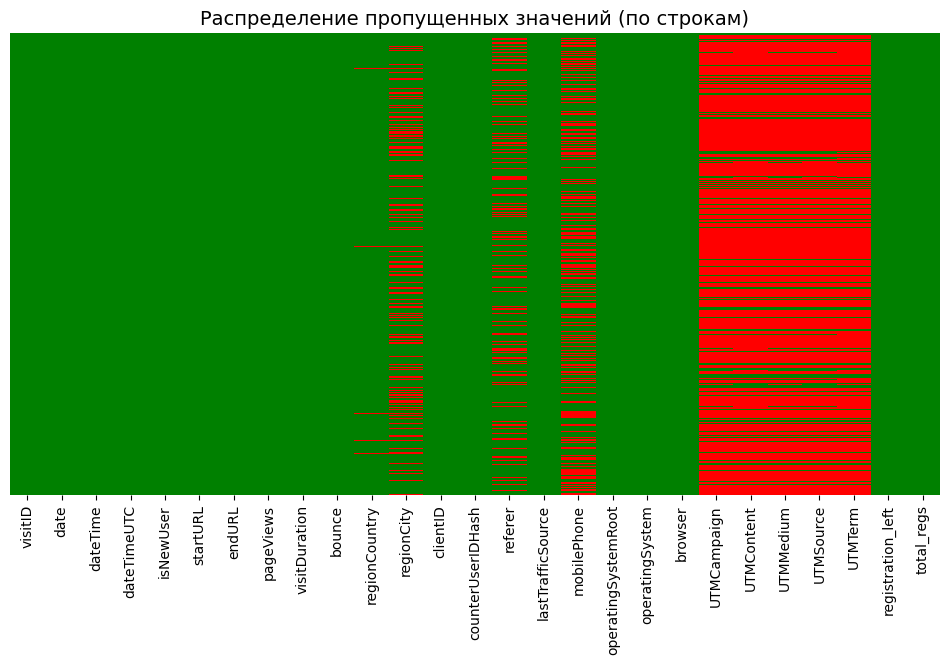

In [5]:
# Проверим датасет на пустые значения
print(data.isnull().sum())

plt.figure(figsize=(12, 6))
sns.heatmap(
    data.isnull(),  # используем полную матрицу пропусков
    cmap=['green', 'red'],  # зеленый=нет пропусков, красный=есть пропуски
    cbar=False,
    yticklabels=False
)
plt.title('Распределение пропущенных значений (по строкам)', fontsize=14)
plt.show()

В датасете присутсвуют пустые ячейки в таких столбцах как: regionCountry - 2314, regionCity - 84926, referer - 73044, mobilePhone - 120644, operatingSystemRoot - 163, operatingSystem - 163, browser - 15, UTMCampaign - 276527, UTMContent - 281023, UTMMedium - 276521, UTMSource - 276763, UTMTerm - 285086

Удалим нефункциональные или повторяющие информацию столбцы

In [6]:
data.drop(['dateTime' ,'dateTimeUTC','counterUserIDHash','operatingSystem','mobilePhone'] , axis =1 ,inplace = True)
data.head()

,visitID,date,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,regionCountry,regionCity,...,lastTrafficSource,operatingSystemRoot,browser,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs
0,4.930130e+18,2024-08-24,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,Russia,Chelyabinsk,...,organic,android,yandex_browser,NaN,NaN,NaN,NaN,NaN,False,0
1,4.931196e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,Russia,Moscow,...,organic,ios_double,safari_mobile,NaN,NaN,NaN,NaN,NaN,False,0
2,4.931401e+18,2024-08-24,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,Russia,Novosibirsk,...,internal,windows,chrome,NaN,NaN,NaN,NaN,NaN,False,0
3,4.933370e+18,2024-08-24,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,Russia,NaN,...,organic,android,yandexsearch,NaN,NaN,NaN,NaN,NaN,False,0
4,4.929749e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,Russia,NaN,...,organic,android,chromemobile,NaN,NaN,NaN,NaN,NaN,False,0


Рассмотрим категориальные признаки. Обернем их в список, посчитаем количество уникальных значений.

In [7]:
for col in ['startURL', 'endURL', 'regionCountry', 'regionCity', 'referer',
            'lastTrafficSource', 'operatingSystemRoot', 'browser',
            'UTMCampaign', 'UTMContent', 'UTMMedium', 'UTMSource', 'UTMTerm']:
    
    unique_values = data[col].unique()
    print(f"{col}:")
    print(unique_values)
    print(f"Количество уникальных значений: {data[col].nunique()}\n")

startURL:
['https://chelyabinsk.propostuplenie.ru/vuzi/chiep-im-m-v-ladoshina/'
 'https://maximumtest.ru/uchebnik/10-klass/biologiya/urovni-organizatsii-zhivoy-prirody'
 'https://education.maximumtest.ru/student/courses' ...
 'https://propostuplenie.ru/navigator/ekaterinburg?erid=LjN8K34N6'
 'https://maximumtest.ru/promo/soprovozhdenie?utm_referrer=https:%2F%2Fmaximumtest-ru.turbopages.org%2Fpromo%2Fmedia%2Fmaximumtest%2Fuspeshnoe-postuplenie-v-vuz-ot-ege-do-priemnoi-komissii-662a4c484008be2844affac6%3Fyzclid%3D7832475502719795199'
 'https://education.maximumtest.ru/webinar/2372765']
Количество уникальных значений: 36923

endURL:
['https://chelyabinsk.propostuplenie.ru/vuzi/chiep-im-m-v-ladoshina/'
 'https://maximumtest.ru/uchebnik/10-klass/biologiya/urovni-organizatsii-zhivoy-prirody'
 'https://education.maximumtest.ru/student/courses' ...
 'https://propostuplenie.ru/navigator/ekaterinburg?erid=LjN8K34N6'
 'https://maximumtest.ru/saratov/conditions/teachers'
 'https://education.maximu

Обработаем UTM метки

In [8]:
for col in ['UTMCampaign', 'UTMContent', 'UTMMedium', 'UTMSource', 'UTMTerm']:
    print(f"{col}: {data[col].nunique()} уникальных значений")

UTMCampaign: 17153 уникальных значений
UTMContent: 39899 уникальных значений
UTMMedium: 292 уникальных значений
UTMSource: 182 уникальных значений
UTMTerm: 17680 уникальных значений


In [9]:
# Категории с очень низкой частотой заменяем на 'other':
threshold = 10
for col in ['UTMCampaign', 'UTMContent', 'UTMMedium', 'UTMSource', 'UTMTerm']:
    value_counts = data[col].value_counts()
    rare_values = value_counts[value_counts < threshold].index
    data[col] = data[col].apply(lambda x: 'other' if x in rare_values else x)
    

In [10]:
# Рассмотрим, какие значения наиболее часто встречаются в UTM-метках;
for col in ['UTMCampaign', 'UTMContent', 'UTMMedium', 'UTMSource', 'UTMTerm']:
    print(f"\n{col} — value_counts:")
    print(data[col].value_counts())



UTMCampaign — value_counts:
UTMCampaign
other                                                                                                                           18457
onl_cpc_yandex_seti_proforientation_all_all_88103099                                                                             1760
onl_cpc_yandex_mk_proforientation_all_all_81198820                                                                               1728
onl_cpc_yandex_master-campaign_proforientation_all_all_86643241                                                                  1444
onl_cpc_yandex_master-campaign_proforientation_all_all_83041950                                                                  1415
                                                                                                                                ...  
ofl_cpm_ya-zen_traffic_navi_all_ekb-kolledzhi_R | 11.05-12.05 Офлайн-навигатор. Екатеринбург (3 лучшие статьи) Охват (новая)       10
kate_pro_dosugNEW    

Видим, что у UTM меток много пропусков, а также много уникальных значений => сложно найти закономерности. В связи с этим столбцы удаляем

In [11]:
data.drop(['UTMCampaign','UTMContent','UTMMedium','UTMSource','UTMTerm'], axis=1 ,inplace = True)
data.head()

,visitID,date,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,regionCountry,regionCity,clientID,referer,lastTrafficSource,operatingSystemRoot,browser,registration_left,total_regs
0,4.930130e+18,2024-08-24,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,Russia,Chelyabinsk,17245157535860290,https://yandex.ru/,organic,android,yandex_browser,False,0
1,4.931196e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,Russia,Moscow,17245198185452598,https://google.com/,organic,ios_double,safari_mobile,False,0
2,4.931401e+18,2024-08-24,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,Russia,Novosibirsk,170021134727181286,https://education.maximumtest.ru/,internal,windows,chrome,False,0
3,4.933370e+18,2024-08-24,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,Russia,NaN,172148976649966933,https://yandex.ru/searchapp?text=,organic,android,yandexsearch,False,0
4,4.929749e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,Russia,NaN,172451430050488742,https://yandex.ru/,organic,android,chromemobile,False,0


Обработаем признаки для модели. Начнем с browser

In [12]:
# у browser есть пропуски
print(f'Пустых значений: {data['browser'].isna().sum()}\n')
# Заменим их на пустые строки
data['browser'] = data['browser'].fillna('Unknown')

Пустых значений: 15



Посмотрим на количество уникальных значений в оставшихся категориальных столбцах и подготовим их к кодированию, присвоив самым популярным категориям отдельную категорию, а менее часто встречающиеся отдадим в other

In [13]:
threshold = 3800
browser_counts = data['browser'].value_counts()
rare_browsers = browser_counts[browser_counts < threshold].index

data['browser'] = data['browser'].apply(lambda x: 'other' if x in rare_browsers else x)
print(data['browser'].value_counts())

print("Уникальных браузеров после обработки:", data['browser'].nunique())

browser
chromemobile        109337
yandex_browser       57849
safari_mobile        47768
chrome               41186
yandexsearch         21534
other                11134
edge                 10272
opera                 8522
yasearchapp           7140
googlesearch          4825
safari                4774
samsung_internet      4281
android_browser       3901
Name: count, dtype: int64
Уникальных браузеров после обработки: 13


Обработаем startURL и endURL

In [14]:
# Разберем startURL на части
def parse_url_parts(url):
    parsed = urlparse(url)
    return pd.Series({
        'url_domain': parsed.netloc,
        'url_path': parsed.path,
        'url_query': parsed.query
    })

# Применяем к колонке startURL
data[['start_url_domain', 'start_url_path', 'start_url_query']] = data['startURL'].apply(parse_url_parts)

# Применяем к колонке endURL
data[['end_url_domain', 'end_url_path', 'end_url_query']] = data['endURL'].apply(parse_url_parts)


In [15]:
print('Для start_URL')
print('Уникальных доменов:', data['start_url_domain'].nunique())
print('Уникальных путей:', data['start_url_path'].nunique())
print('Уникальных query-параметров:', data['start_url_query'].nunique())
print()
print('Для end_URL')
print('Уникальных доменов:', data['end_url_domain'].nunique())
print('Уникальных путей:', data['end_url_path'].nunique())
print('Уникальных query-параметров:', data['end_url_query'].nunique())


Для start_URL
Уникальных доменов: 297
Уникальных путей: 23161
Уникальных query-параметров: 10895

Для end_URL
Уникальных доменов: 300
Уникальных путей: 27897
Уникальных query-параметров: 10491


Оставили только домены, так как пути и query-параметры содержат много лишних данных  

In [16]:
# Проверяем количество пустых значений в столбце operatingSystemRoot
missing_values_count = data['operatingSystemRoot'].isna().sum()

# Выводим результат
print(f'Количество пустых значений в operatingSystemRoot: {missing_values_count}')

Количество пустых значений в operatingSystemRoot: 163


In [17]:
# Заменим пустые значения на Unknown
data['operatingSystemRoot'] = data['operatingSystemRoot'].fillna('Unknown')

In [18]:
threshold = 2200
os_root_counts = data['operatingSystemRoot'].value_counts()
rare_os_root = os_root_counts[os_root_counts < threshold].index

data['operatingSystemRoot'] = data['operatingSystemRoot'].apply(lambda x: 'other' if x in rare_os_root else x)

print(data['operatingSystemRoot'].value_counts())
print("Уникальных operatingSystemRoot после обработки:", data['operatingSystemRoot'].nunique())


operatingSystemRoot
android       163898
windows        95060
ios_double     63294
macos           7226
gnu_linux       2867
other            178
Name: count, dtype: int64
Уникальных operatingSystemRoot после обработки: 6


Обработаем lastTrafficSource

In [19]:
# у lastTrafficSource нет пропусков
print(f'Пустых значений: {data['lastTrafficSource'].isna().sum()}\n')

# Но есть крайне малые значения, их можем отбросить
data_6=data.groupby('lastTrafficSource')['lastTrafficSource'].count()
print(data_6.sort_values(ascending=False))
print()

threshold = 1000
last_traffic_source_counts = data['lastTrafficSource'].value_counts()
rare_last_traffic_source_counts = last_traffic_source_counts[last_traffic_source_counts < threshold].index

data['lastTrafficSource'] = data['lastTrafficSource'].apply(lambda x: 'other' if x in rare_last_traffic_source_counts else x)

print(data['lastTrafficSource'].value_counts())
print("\nУникальных lastTrafficSource после обработки:", data['lastTrafficSource'].nunique())


Пустых значений: 0

lastTrafficSource
organic      178846
direct        63800
ad            44055
internal      35449
referral       6805
social         1963
email          1259
messenger       217
recommend       108
undefined        19
saved             2
Name: lastTrafficSource, dtype: int64

lastTrafficSource
organic     178846
direct       63800
ad           44055
internal     35449
referral      6805
social        1963
email         1259
other          346
Name: count, dtype: int64

Уникальных lastTrafficSource после обработки: 8


In [20]:
# у referer есть пропуски
print(f'Пустых значений: {data['referer'].isna().sum()}\n')
# Заменим их на пустые строки ()
data['referer'] = data['referer'].fillna('')

# Применяем к колонкеreferer
data[['referer_domain', 'referer_path', 'referer_query']] = data['referer'].apply(parse_url_parts)

print('Для referer')
print('Уникальных доменов:', data['referer_domain'].nunique())
print('Уникальных путей:', data['referer_path'].nunique())
print('Уникальных query-параметров:', data['referer_query'].nunique())


Пустых значений: 73044

Для referer
Уникальных доменов: 1628
Уникальных путей: 6610
Уникальных query-параметров: 5292


In [21]:
# Будем работать только с доменами, но перед этим заполним их пустые строки на direct (обозначает, что источник перехода неизвестен или прямой)
data['referer_domain'] = data['referer_domain'].fillna('direct')

# Сокращаем количество доменов
threshold = 1500
domain_counts = data['referer_domain'].value_counts()
rare_domains = domain_counts[domain_counts < threshold].index
data['referer_domain'] = data['referer_domain'].apply(lambda x: 'other' if x in rare_domains else x)

print(data['referer_domain'].value_counts())
print("\nУникальных referer_domain после обработки:", data['referer_domain'].nunique())



referer_domain
yandex.ru                           113542
google.com                           77277
                                     73044
education.maximumtest.ru             25208
other                                19560
ya.ru                                 6368
google.ru                             4545
pruffme.com                           2743
maximumtest.ru                        2643
login.maximumtest.ru                  2294
propostuplenie.ru                     1885
maximumtest-ru.turbopages.org         1710
propostuplenie-ru.turbopages.org      1704
Name: count, dtype: int64

Уникальных referer_domain после обработки: 13


Обработаем столбцы regionCountry и regionCity

In [22]:
# Считаем пропуски
print(f'Пустых значений у regionCountry: {data['regionCountry'].isna().sum()}')
print(f'Пустых значений у regionCity: {data['regionCity'].isna().sum()}\n')

# % пропусков для regionCountry
missing_percentage_country = data['regionCountry'].isna().mean() * 100
print(f'Процент пропусков у regionCountry: {missing_percentage_country:.2f}%')
# % пропусков для regionCity
missing_percentage_city = data['regionCity'].isna().mean() * 100
print(f'Процент пропусков у regionCity: {missing_percentage_city:.2f}%')


Пустых значений у regionCountry: 2314
Пустых значений у regionCity: 84926

Процент пропусков у regionCountry: 0.70%
Процент пропусков у regionCity: 25.54%


Чтобы исключить влияние ВПН, создадим функцию, которая удалит все страны кроме РФ

In [23]:
def drop_country(df, country_column):
# Создадим условие, где True соответствует строкам, где страна - Russia
  is_russia = df[country_column] == 'Russia'

  # Фильтруем DataFrame, оставляя только строки, соответствующие условию
  df_filtered = df[is_russia]

  return df_filtered

# Применяем на датасете функцию
data = drop_country(data, 'regionCountry')

# Выводим результат
print(data)

             visitID        date  isNewUser  \
0       4.930130e+18  2024-08-24          1   
1       4.931196e+18  2024-08-24          1   
2       4.931401e+18  2024-08-24          0   
3       4.933370e+18  2024-08-24          0   
4       4.929749e+18  2024-08-24          1   
...              ...         ...        ...   
332517  2.307039e+18  2024-04-30          1   
332518  2.307211e+18  2024-04-30          1   
332519  2.305394e+18  2024-04-30          1   
332521  2.290737e+18  2024-04-30          1   
332522  2.299687e+18  2024-04-30          0   

                                                 startURL  \
0       https://chelyabinsk.propostuplenie.ru/vuzi/chi...   
1       https://maximumtest.ru/uchebnik/10-klass/biolo...   
2        https://education.maximumtest.ru/student/courses   
3       https://blog.maximumtest.ru/post/opublikovano-...   
4       https://maximumtest.ru/uchebnik/5-klass/matema...   
...                                                   ...   
332517  

In [24]:
# Проверим уникальное количество значений в регионах
print('Уникальных значений для regionCountry:', data['regionCountry'].nunique())
print('Уникальных значений для regionCity:', data['regionCity'].nunique())

Уникальных значений для regionCountry: 1
Уникальных значений для regionCity: 858


Таким образом, остались только строки с посещениями из РФ, благодаря чему исключены заходы с использованием ВПН

Посмотрим теперь на города в датасете

In [25]:
data_regionCity=data.groupby('regionCity')['regionCity'].count()
print(data_regionCity.sort_values(ascending=False).head(15))

regionCity
Moscow              68203
Saint Petersburg    24376
Nizhny Novgorod      9082
Yekaterinburg        7489
Novosibirsk          6144
Krasnodar            5097
Domodedovo           4349
Chelyabinsk          3105
Kazan                2539
Irkutsk              2522
Krasnoyarsk          2484
Tver                 2428
Samara               2284
Rostov-na-Donu       2280
Volgograd            2256
Name: regionCity, dtype: int64


Создаем новые 2 признака с широтой и долготой городов, указанных в датафрейме. Для этого используем, найденный датасет в интернете

In [26]:
# Читаем файл
data_coord_city = pd.read_csv('cities.csv')
#смотрим, что внутри
data_coord_city.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,...,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.0,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,...,4: город,0,79403000000,7.970300e+10,107,UTC+3,44.878372,39.190172,Южный,12689
1,385000.0,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,...,4: город,2,79401000000,7.970100e+10,105,UTC+3,44.609827,40.100653,Южный,144055
2,649000.0,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,...,4: город,2,84401000000,8.470100e+07,400,UTC+7,51.958268,85.960296,Сибирский,62861
3,658125.0,край,Алтайский,NaN,NaN,г,Алейск,NaN,NaN,2200000200000,...,4: город,0,1403000000,1.703000e+06,2201,UTC+7,52.492091,82.779415,Сибирский,28528
4,656000.0,край,Алтайский,NaN,NaN,г,Барнаул,NaN,NaN,2200000100000,...,4: город,2,1401000000,1.701000e+06,2200,UTC+7,53.348115,83.779836,Сибирский,635585


В данном дата сете Санкт-Петербург и Москва это города федерального значения и они записаны только как регион. Добавим их названия в столбец город, сразу в транслите. А также Нижний новгород, потому что он имеет сложное название, которое траслит может неправильно передать

In [27]:
data_coord_city.loc[data_coord_city['Регион'] == 'Москва', 'Город'] = 'Moscow'
data_coord_city.loc[data_coord_city['Регион'] == 'Санкт-Петербург', 'Город'] = 'Saint Petersburg'
data_coord_city.loc[data_coord_city['Город'] == 'Нижний Новгород', 'Город'] = 'Nizhny Novgorod'


In [28]:
# Т.к. внутри данного дата фрейма названия городов написаны на русском, а в исходном транслитом, переделаем столбец
def transliterate_column(df, column_name):
    translit_dict = {
        'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e', 'ё': 'e',
        'ж': 'zh', 'з': 'z', 'и': 'i', 'й': 'y', 'к': 'k', 'л': 'l', 'м': 'm',
        'н': 'n', 'о': 'o', 'п': 'p', 'р': 'r', 'с': 's', 'т': 't', 'у': 'u',
        'ф': 'f', 'х': 'kh', 'ц': 'ts', 'ч': 'ch', 'ш': 'sh', 'щ': 'sch',
        'ъ': '', 'ы': 'y', 'ь': '', 'э': 'e', 'ю': 'yu', 'я': 'ya',
        'А': 'A', 'Б': 'B', 'В': 'V', 'Г': 'G', 'Д': 'D', 'Е': 'E', 'Ё': 'E',
        'Ж': 'Zh', 'З': 'Z', 'И': 'I', 'Й': 'Y', 'К': 'K', 'Л': 'L', 'М': 'M',
        'Н': 'N', 'О': 'O', 'П': 'P', 'Р': 'R', 'С': 'S', 'Т': 'T', 'У': 'U',
        'Ф': 'F', 'Х': 'Kh', 'Ц': 'Ts', 'Ч': 'Ch', 'Ш': 'Sh', 'Щ': 'Sch',
        'Ъ': '', 'Ы': 'Y', 'Ь': '', 'Э': 'E', 'Ю': 'Yu', 'Я': 'Ya'
    }

    def transliterate_word(word):
        transliterated_word = ''.join(translit_dict.get(char, char) for char in word)
        return transliterated_word

    df[column_name] = df[column_name].astype(str).apply(transliterate_word)  # Преобразуем в строку, чтобы избежать ошибок
    return df

# Транслитерируем столбец 'Город'
data_coord_city_transl = transliterate_column(data_coord_city, 'Город')

# Выводим результат
print(data_coord_city_transl)

        Индекс Тип региона       Регион Тип района       Район Тип города  \
0     385200.0        Респ       Адыгея        NaN         NaN          г   
1     385000.0        Респ       Адыгея        NaN         NaN          г   
2     649000.0        Респ        Алтай        NaN         NaN          г   
3     658125.0        край    Алтайский        NaN         NaN          г   
4     656000.0        край    Алтайский        NaN         NaN          г   
...        ...         ...          ...        ...         ...        ...   
1107  152150.0         обл  Ярославская        р-н  Ростовский          г   
1108  152900.0         обл  Ярославская        р-н   Рыбинский          г   
1109  152300.0         обл  Ярославская        р-н  Тутаевский          г   
1110  152610.0         обл  Ярославская        р-н   Угличский          г   
1111  150000.0         обл  Ярославская        NaN         NaN          г   

              Город Тип н/п  Н/п      Код КЛАДР  ... Уровень по ФИАС  \
0  

In [29]:
data_coord_city.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,...,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.0,Респ,Адыгея,NaN,NaN,г,Adygeysk,NaN,NaN,100000200000,...,4: город,0,79403000000,7.970300e+10,107,UTC+3,44.878372,39.190172,Южный,12689
1,385000.0,Респ,Адыгея,NaN,NaN,г,Maykop,NaN,NaN,100000100000,...,4: город,2,79401000000,7.970100e+10,105,UTC+3,44.609827,40.100653,Южный,144055
2,649000.0,Респ,Алтай,NaN,NaN,г,Gorno-Altaysk,NaN,NaN,400000100000,...,4: город,2,84401000000,8.470100e+07,400,UTC+7,51.958268,85.960296,Сибирский,62861
3,658125.0,край,Алтайский,NaN,NaN,г,Aleysk,NaN,NaN,2200000200000,...,4: город,0,1403000000,1.703000e+06,2201,UTC+7,52.492091,82.779415,Сибирский,28528
4,656000.0,край,Алтайский,NaN,NaN,г,Barnaul,NaN,NaN,2200000100000,...,4: город,2,1401000000,1.701000e+06,2200,UTC+7,53.348115,83.779836,Сибирский,635585


Поменям название столбца в этом датасете, чтобы можно было сопоставить два датасета

In [30]:
data_coord_city = data_coord_city.rename(columns={'Город': 'regionCity'})

In [31]:
# Создадим функцию по добавлению столбов, соответствующих координатам городов 

def update_coordinates(df1, df2, join_column, lat_col_df2, lon_col_df2):
    
    # Убираем дубликаты в df2 по join_column перед созданием словаря
    df2_unique = df2.drop_duplicates(subset=[join_column], keep='first')

    # Создаем словарь соответствий значений join_column в df2 -> (широта, долгота)
    coord_dict = df2_unique.set_index(join_column)[[lat_col_df2, lon_col_df2]].to_dict('index')

    # Функция для получения координат по значению из столбца join_column
    def get_coords(join_value):
        if join_value in coord_dict:
            return coord_dict[join_value][lat_col_df2], coord_dict[join_value][lon_col_df2]
        else:
            return None, None  # Если нет соответствия, возвращаем None, None

    # Применяем функцию get_coords к df1 и обновляем столбцы 'Широта' и 'Долгота'
    # Создаем новые столбцы, если их нет
    if 'Широта' not in df1.columns:
        df1['Широта'] = None
    if 'Долгота' not in df1.columns:
        df1['Долгота'] = None

    df1[['Широта', 'Долгота']] = df1[join_column].apply(lambda x: pd.Series(get_coords(x)))

    return df1

# Обновляем координаты в df1
data = update_coordinates(data, data_coord_city, 'regionCity', 'Широта', 'Долгота')

# Выводим результат
print(data)

             visitID        date  isNewUser  \
0       4.930130e+18  2024-08-24          1   
1       4.931196e+18  2024-08-24          1   
2       4.931401e+18  2024-08-24          0   
3       4.933370e+18  2024-08-24          0   
4       4.929749e+18  2024-08-24          1   
...              ...         ...        ...   
332517  2.307039e+18  2024-04-30          1   
332518  2.307211e+18  2024-04-30          1   
332519  2.305394e+18  2024-04-30          1   
332521  2.290737e+18  2024-04-30          1   
332522  2.299687e+18  2024-04-30          0   

                                                 startURL  \
0       https://chelyabinsk.propostuplenie.ru/vuzi/chi...   
1       https://maximumtest.ru/uchebnik/10-klass/biolo...   
2        https://education.maximumtest.ru/student/courses   
3       https://blog.maximumtest.ru/post/opublikovano-...   
4       https://maximumtest.ru/uchebnik/5-klass/matema...   
...                                                   ...   
332517  

In [32]:
data.head()

,visitID,date,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,regionCountry,regionCity,...,start_url_path,start_url_query,end_url_domain,end_url_path,end_url_query,referer_domain,referer_path,referer_query,Широта,Долгота
0,4.930130e+18,2024-08-24,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,Russia,Chelyabinsk,...,/vuzi/chiep-im-m-v-ladoshina/,,chelyabinsk.propostuplenie.ru,/vuzi/chiep-im-m-v-ladoshina/,,yandex.ru,/,,55.160366,61.400786
1,4.931196e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,Russia,Moscow,...,/uchebnik/10-klass/biologiya/urovni-organizats...,,maximumtest.ru,/uchebnik/10-klass/biologiya/urovni-organizats...,,google.com,/,,55.753879,37.620373
2,4.931401e+18,2024-08-24,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,Russia,Novosibirsk,...,/student/courses,,education.maximumtest.ru,/student/courses,,education.maximumtest.ru,/,,55.028102,82.921058
3,4.933370e+18,2024-08-24,0,https://blog.maximumtest.ru/post/opublikovano-...,https://blog.maximumtest.ru/post/opublikovano-...,1,15,0,Russia,NaN,...,/post/opublikovano-raspisanie-rabot-statgrad-p...,,blog.maximumtest.ru,/post/opublikovano-raspisanie-rabot-statgrad-p...,,yandex.ru,/searchapp,text=,NaN,NaN
4,4.929749e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/5-klass/matema...,https://maximumtest.ru/uchebnik/5-klass/matema...,1,1,1,Russia,NaN,...,/uchebnik/5-klass/matematika/obyknovennye-drob...,,maximumtest.ru,/uchebnik/5-klass/matematika/obyknovennye-drob...,,yandex.ru,/,,NaN,NaN


In [33]:
data.isnull().sum()

visitID                    0
date                       0
isNewUser                  0
startURL                   0
endURL                     0
pageViews                  0
visitDuration              0
bounce                     0
regionCountry              0
regionCity             77415
clientID                   0
referer                    0
lastTrafficSource          0
operatingSystemRoot        0
browser                    0
registration_left          0
total_regs                 0
start_url_domain           0
start_url_path             0
start_url_query            0
end_url_domain             0
end_url_path               0
end_url_query              0
referer_domain             0
referer_path               0
referer_query              0
Широта                 95913
Долгота                95913
dtype: int64

Удалим все строки, в которых не указаны города и одновременно широта и долгота

In [34]:
data = data.dropna(subset=['Широта','Долгота'])

Удалим столбец regionCountry, тк он нам больше не понадобится

In [35]:
data=data.drop('regionCountry', axis=1)

Теперь обсудим столбец с датами.

In [36]:
# Средняя продолжительность визита пр информация
print(data['visitDuration'].describe())

count    202436.000000
mean        321.272990
std         952.692182
min           0.000000
25%          14.000000
50%          29.000000
75%         156.000000
max       26112.000000
Name: visitDuration, dtype: float64


In [37]:
# Преобразуем колонку к datetime
data['date'] = pd.to_datetime(data['date'])
# Распределяем по дням недели, где 0 - понедельник, 6 - воскресенье
data['weekday'] = data['date'].dt.weekday
# Добавил распределение по месяцам (возможно в августе-сентябре рег будет больше)
data['month'] = data['date'].dt.month
# Определяем выходной(1)/будний(1) день
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Частота по дням недели
print(data['weekday'].value_counts())
print('------------------------------------')
# Сравнение визитов по рабочим и выходным
print(data['is_weekend'].value_counts(normalize=True))

data.head()

weekday
2    32155
1    32101
0    31537
3    31225
4    26770
6    25490
5    23158
Name: count, dtype: int64
------------------------------------
is_weekend
0    0.759687
1    0.240313
Name: proportion, dtype: float64


,visitID,date,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,regionCity,clientID,...,end_url_path,end_url_query,referer_domain,referer_path,referer_query,Широта,Долгота,weekday,month,is_weekend
0,4.930130e+18,2024-08-24,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,Chelyabinsk,17245157535860290,...,/vuzi/chiep-im-m-v-ladoshina/,,yandex.ru,/,,55.160366,61.400786,5,8,1
1,4.931196e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,Moscow,17245198185452598,...,/uchebnik/10-klass/biologiya/urovni-organizats...,,google.com,/,,55.753879,37.620373,5,8,1
2,4.931401e+18,2024-08-24,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,Novosibirsk,170021134727181286,...,/student/courses,,education.maximumtest.ru,/,,55.028102,82.921058,5,8,1
5,4.929898e+18,2024-08-24,1,https://propostuplenie.ru/article/13-voprosov-...,https://propostuplenie.ru/article/13-voprosov-...,1,15,0,Novosibirsk,172451486857336188,...,/article/13-voprosov-o-platnom-obuchenii-v-vuz...,,google.com,/,,55.028102,82.921058,5,8,1
6,4.930240e+18,2024-08-24,1,https://kemerovo.propostuplenie.ru/vuzi/kemgu/...,https://kemerovo.propostuplenie.ru/vuzi/kemgu/...,1,20,0,Moscow,172451617318004592,...,/vuzi/kemgu/logopediya-rannyaya-diagnostika-i-...,,yandex.ru,/,,55.753879,37.620373,5,8,1


Добавим фичу по визитам клиента

In [38]:
# Добавим фичу - время, проведенное в среднем за просмотром 1 страницы
data['time_one_page']=data['visitDuration']/data['pageViews']
data.head() 

# Максимальное значение
max_time_one_page = data['time_one_page'].max()

# Минимальное значение
min_time_one_page = data['time_one_page'].min()

print(f"Максимальное время на одну страницу: {max_time_one_page}")
print(f"Минимальное время на одну страницу: {min_time_one_page}")



Максимальное время на одну страницу: 15498.0
Минимальное время на одну страницу: 0.0


In [39]:
# Чтобы выбросы сильно не влияли
# Применяем логарифмическую трансформацию с добавлением 1 (чтобы избежать log(0))
data['log_time_one_page'] = np.log1p(data['time_one_page'])

In [40]:
# Проверяем результат
print(data[['time_one_page', 'log_time_one_page']].head())

   time_one_page  log_time_one_page
0            0.0           0.000000
1          335.0           5.817111
2           19.0           2.995732
5           15.0           2.772589
6           20.0           3.044522


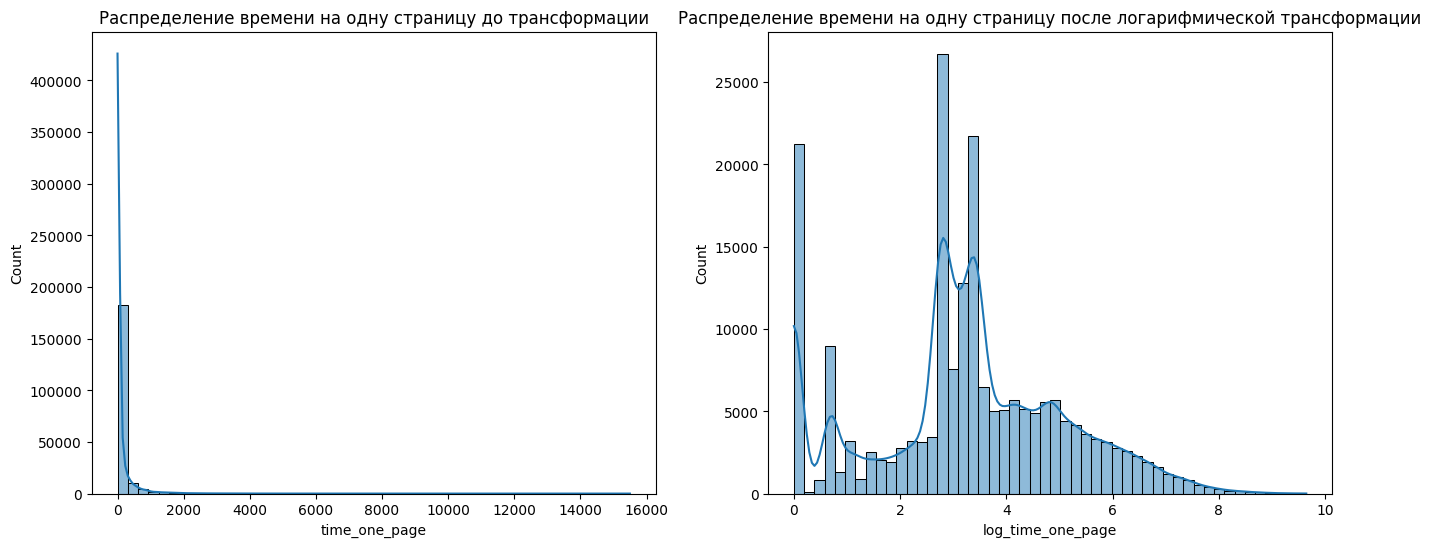

In [41]:
# Построение гистограммы до и после трансформации
plt.figure(figsize=(16, 6))

# До трансформации
plt.subplot(1, 2, 1)
sns.histplot(data['time_one_page'], bins=50, kde=True)
plt.title('Распределение времени на одну страницу до трансформации')

# После трансформации
plt.subplot(1, 2, 2)
sns.histplot(data['log_time_one_page'], bins=50, kde=True)
plt.title('Распределение времени на одну страницу после логарифмической трансформации')

plt.show()

График показывает, что распределение времени на одну страницу до логарифмической трансформации сильно скошено вправо из-за большого количества выбросов.  
После логарифмирования распределение стало более симметричным и пригодным для анализа и моделирования.  
Такая трансформация помогает улучшить работу статистических и ML-моделей, которые чувствительны к выбросам и ненормальности данных.

Создаем целевую переменную leave

In [42]:
# Кол-во визитов пользователя
user_visits = data.groupby('clientID')['visitID'].count()

# Не дропаем visitID тк оно понадобится нам далее

# Если визит один — значит ушел (leave)
leave = user_visits == 1

data['leave'] = data['clientID'].map(leave).astype(int)
data.head()


,visitID,date,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,regionCity,clientID,...,referer_path,referer_query,Широта,Долгота,weekday,month,is_weekend,time_one_page,log_time_one_page,leave
0,4.930130e+18,2024-08-24,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,0,1,Chelyabinsk,17245157535860290,...,/,,55.160366,61.400786,5,8,1,0.0,0.000000,1
1,4.931196e+18,2024-08-24,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,335,0,Moscow,17245198185452598,...,/,,55.753879,37.620373,5,8,1,335.0,5.817111,1
2,4.931401e+18,2024-08-24,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,19,0,Novosibirsk,170021134727181286,...,/,,55.028102,82.921058,5,8,1,19.0,2.995732,0
5,4.929898e+18,2024-08-24,1,https://propostuplenie.ru/article/13-voprosov-...,https://propostuplenie.ru/article/13-voprosov-...,1,15,0,Novosibirsk,172451486857336188,...,/,,55.028102,82.921058,5,8,1,15.0,2.772589,1
6,4.930240e+18,2024-08-24,1,https://kemerovo.propostuplenie.ru/vuzi/kemgu/...,https://kemerovo.propostuplenie.ru/vuzi/kemgu/...,1,20,0,Moscow,172451617318004592,...,/,,55.753879,37.620373,5,8,1,20.0,3.044522,1


C:\Users\likha\AppData\Local\Temp\ipykernel_20860\3362969439.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['leave'], palette='viridis')


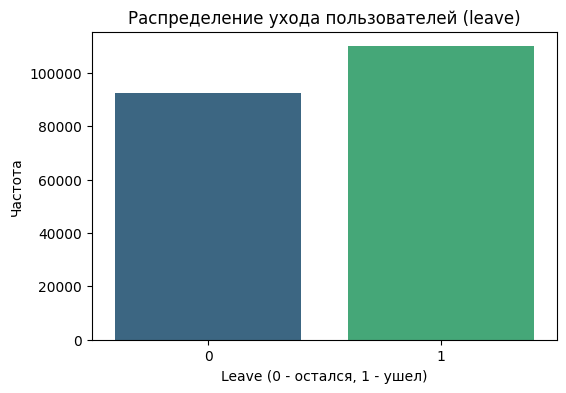

In [43]:
# Построим график распределения классов leave
plt.figure(figsize=(6, 4))
sns.countplot(x=data['leave'], palette='viridis')
plt.title('Распределение ухода пользователей (leave)')
plt.xlabel('Leave (0 - остался, 1 - ушел)')
plt.ylabel('Частота')
plt.show()

In [44]:
print("Соотношение классов:\n", data['leave'].value_counts(normalize=True))

Соотношение классов:
 leave
1    0.543224
0    0.456776
Name: proportion, dtype: float64


Балансировка классов не является критически необходимой: Соотношение классов близко к 50/50 (разница всего 11%), что не является сильным дисбалансом.


In [45]:
# Удаляем дату, visitID, clientID:
data.drop(['date', 'visitID', 'clientID'] , axis =1 ,inplace = True)

In [46]:
# Удаляем старый столбец с referer_domain и все побочные столбцы
data.drop(['referer', 'referer_path', 'referer_query'] , axis =1 ,inplace = True)

Посмотрим числовой параметр 'visitDuration'

C:\Users\likha\AppData\Local\Temp\ipykernel_20860\3117558501.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x='visitDuration', bins=30, kde=True, palette=['#1f77b4', '#ff7f0e'])


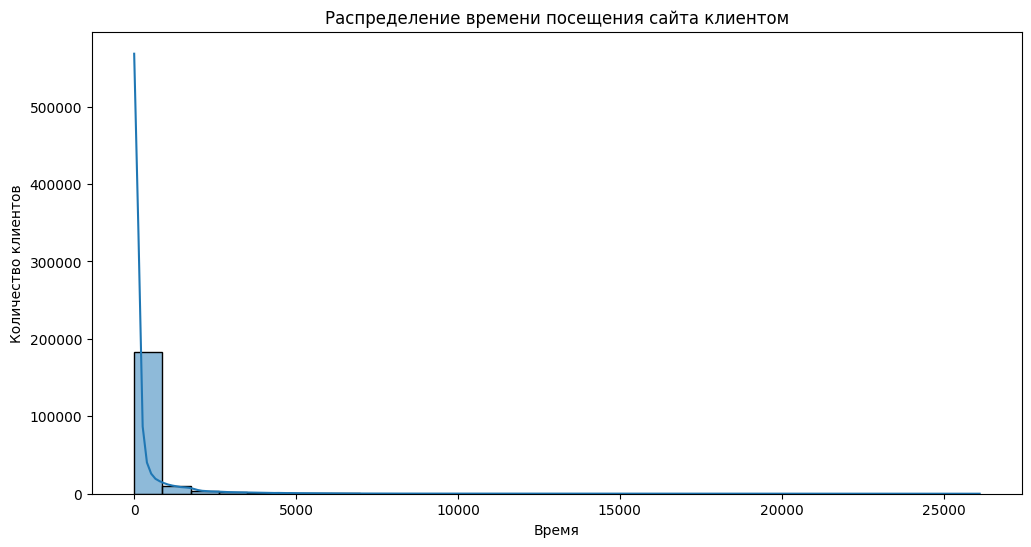

In [47]:
#Построим распределение времени на сайте 
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='visitDuration', bins=30, kde=True, palette=['#1f77b4', '#ff7f0e'])
plt.title('Распределение времени посещения сайта клиентом')
plt.xlabel('Время')
plt.ylabel('Количество клиентов')
plt.show()

Видим, что распределение не равномерное, много выбросов. Проведем логарифмирование, чтобы уменьшить влияние выбросов

In [48]:
# Используем логарифмическую трансформацию чтобы уменьшить влияние "выбросов" с большим количеством визитов. Заполним пустые строки.
data.loc[data['visitDuration'].isna(), 'visitDuration'] = 0
# Применяем логарифм с добавлением 1, чтобы избежать проблем с логарифмом от нуля
data['log_visitDuration'] = np.log1p(data['visitDuration'])

# Проверяем результат
print(data[['log_visitDuration']].head())

   log_visitDuration
0           0.000000
1           5.817111
2           2.995732
5           2.772589
6           3.044522


Для улучшения анализа данных о продолжительности визитов применили логарифм с добавлением 1, чтобы уменьшить влияние очень больших значений (выбросов). Пропущенные значения были заменены на 0, чтобы избежать ошибок.  
Это сделало данные более сбалансированными и позволило уменьшить эффект аномальных визитов на анализ.

In [49]:
#Удаляем старый столбец
data.drop(['visitDuration'] , axis =1 ,inplace = True)

In [50]:
data.head()

,isNewUser,startURL,endURL,pageViews,bounce,regionCity,lastTrafficSource,operatingSystemRoot,browser,registration_left,...,referer_domain,Широта,Долгота,weekday,month,is_weekend,time_one_page,log_time_one_page,leave,log_visitDuration
0,1,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,https://chelyabinsk.propostuplenie.ru/vuzi/chi...,1,1,Chelyabinsk,organic,android,yandex_browser,False,...,yandex.ru,55.160366,61.400786,5,8,1,0.0,0.000000,1,0.000000
1,1,https://maximumtest.ru/uchebnik/10-klass/biolo...,https://maximumtest.ru/uchebnik/10-klass/biolo...,1,0,Moscow,organic,ios_double,safari_mobile,False,...,google.com,55.753879,37.620373,5,8,1,335.0,5.817111,1,5.817111
2,0,https://education.maximumtest.ru/student/courses,https://education.maximumtest.ru/student/courses,1,0,Novosibirsk,internal,windows,chrome,False,...,education.maximumtest.ru,55.028102,82.921058,5,8,1,19.0,2.995732,0,2.995732
5,1,https://propostuplenie.ru/article/13-voprosov-...,https://propostuplenie.ru/article/13-voprosov-...,1,0,Novosibirsk,organic,android,chromemobile,False,...,google.com,55.028102,82.921058,5,8,1,15.0,2.772589,1,2.772589
6,1,https://kemerovo.propostuplenie.ru/vuzi/kemgu/...,https://kemerovo.propostuplenie.ru/vuzi/kemgu/...,1,0,Moscow,organic,android,chromemobile,False,...,yandex.ru,55.753879,37.620373,5,8,1,20.0,3.044522,1,3.044522


In [51]:
# Преобразуем столбцы в список для наглядности
column_list = data.columns.tolist()

print(column_list)

['isNewUser', 'startURL', 'endURL', 'pageViews', 'bounce', 'regionCity', 'lastTrafficSource', 'operatingSystemRoot', 'browser', 'registration_left', 'total_regs', 'start_url_domain', 'start_url_path', 'start_url_query', 'end_url_domain', 'end_url_path', 'end_url_query', 'referer_domain', 'Широта', 'Долгота', 'weekday', 'month', 'is_weekend', 'time_one_page', 'log_time_one_page', 'leave', 'log_visitDuration']


isNewUser              0
startURL               0
endURL                 0
pageViews              0
bounce                 0
regionCity             0
lastTrafficSource      0
operatingSystemRoot    0
browser                0
registration_left      0
total_regs             0
start_url_domain       0
start_url_path         0
start_url_query        0
end_url_domain         0
end_url_path           0
end_url_query          0
referer_domain         0
Широта                 0
Долгота                0
weekday                0
month                  0
is_weekend             0
time_one_page          0
log_time_one_page      0
leave                  0
log_visitDuration      0
dtype: int64


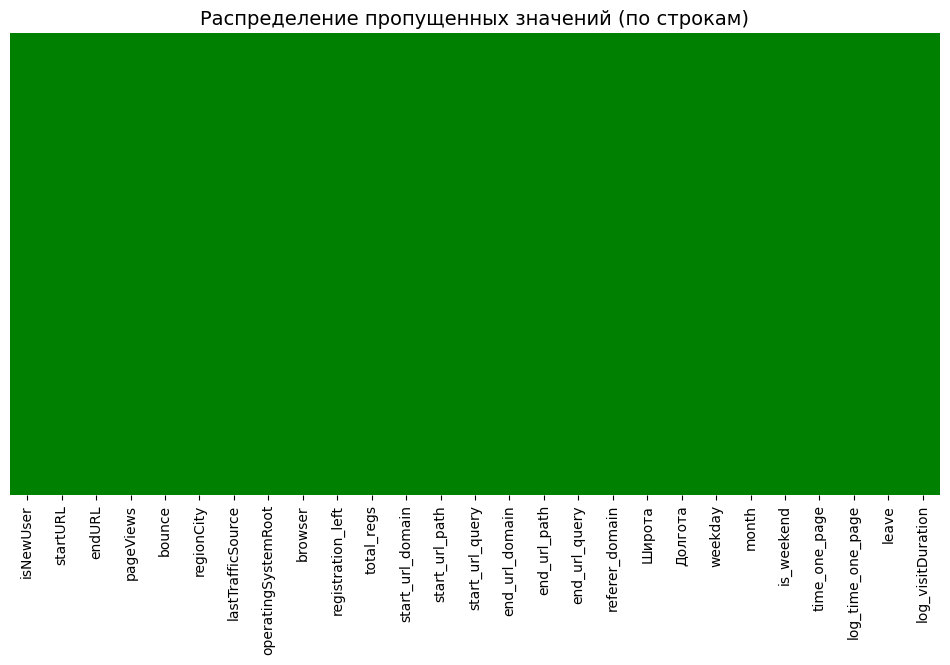

In [52]:
print(data.isnull().sum())

plt.figure(figsize=(12, 6))
sns.heatmap(
    data.isnull(),  # используем полную матрицу пропусков
    cmap=['green', 'red'],  # зеленый=нет пропусков, красный=есть пропуски
    cbar=False,
    yticklabels=False
)
plt.title('Распределение пропущенных значений (по строкам)', fontsize=14)
plt.show()

В наборе данных больше нет пропущенных значений для этих признаков. Следовательно, мы можем работать с полными данными без необходимости их заполнять.

In [53]:
X = data.drop(columns=['leave'])
y = data['leave']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # гарантируем одинаковые доли классов в train и test
)

# Смотрим сколько значений в каждой выборке
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

#Проверим процентное соотношение целевой переменной в выборках
print(f"Доля оттока в train: {y_train.mean():.2f}, в test: {y_test.mean():.2f}")

Train: (161948, 26), Test: (40488, 26)
Доля оттока в train: 0.54, в test: 0.54


После обработки данных, заполнения пропусков и разделения на тренировочную и тестовую выборки, переходим к этапу кодирования признаков.

In [55]:
# start_url_domain и end_url_domain кодируем с помощью OrdinalEncoder, чтобы избежать ошибок
# так как есть значения, которые не встречаются в тестовой выборке
from sklearn.preprocessing import OrdinalEncoder

# Инициализация OrdinalEncoder с параметром handle_unknown='use_encoded_value' - используется для обработки категориальных значений, которые не встречаются в обучающей выборке
# но появляются в тестовых данных или в новых данных. (любые неизвестные значения заменяются на -1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Список столбцов, которые нужно закодировать
url_columns = ['start_url_domain', 'end_url_domain']

# Применяем Label Encoding для каждого столбца
for column in url_columns:
    X_train[column + '_encoded'] = encoder.fit_transform(X_train[[column]]).flatten()
    X_test[column + '_encoded'] = encoder.transform(X_test[[column]]).flatten()
    
    
cols_to_drop = ['startURL', 'endURL', 'start_url_domain', 'end_url_domain', 'start_url_path', 'start_url_query', 'end_url_path', 'end_url_query']
# Удаляем url_path и url_query для startURL и endURL + сами startURL и endURL, тк их уже обработали + start_url_domain и end_url_domain так как это текст
X_train.drop(columns=cols_to_drop, axis=1, inplace=True)
X_test.drop(columns=cols_to_drop, axis=1, inplace=True)

# 6. Проверка форм
print(X_train.shape)
print(X_test.shape)

(161948, 20)
(40488, 20)


Следующие признаки закодируем с помощью One-Hot Encoding, где каждая категория представляется в виде бинарного вектора, в котором только одна из позиций равна 1, а остальные — 0.

In [56]:
# Список категориальных колонок
cat_cols = ['lastTrafficSource', 'weekday', 'month', 'referer_domain', 'operatingSystemRoot', 'browser'] 

# Инициализация OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False , handle_unknown='ignore')

# Обучаем энкодер на X_train
encoded_train = encoder.fit_transform(X_train[cat_cols])
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(cat_cols), index=X_train.index)

# Преобразуем X_test
encoded_test = encoder.transform(X_test[cat_cols])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(cat_cols), index=X_test.index)

# Удаляем исходные категориальные признаки
X_train = pd.concat([X_train.drop(columns=cat_cols), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=cat_cols), encoded_test_df], axis=1)


In [57]:
# Преобразуем столбцы в список для наглядности
column_list = X_train.columns.tolist()

print(column_list)

['isNewUser', 'pageViews', 'bounce', 'regionCity', 'registration_left', 'total_regs', 'Широта', 'Долгота', 'is_weekend', 'time_one_page', 'log_time_one_page', 'log_visitDuration', 'start_url_domain_encoded', 'end_url_domain_encoded', 'lastTrafficSource_direct', 'lastTrafficSource_email', 'lastTrafficSource_internal', 'lastTrafficSource_organic', 'lastTrafficSource_other', 'lastTrafficSource_referral', 'lastTrafficSource_social', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'referer_domain_education.maximumtest.ru', 'referer_domain_google.com', 'referer_domain_google.ru', 'referer_domain_login.maximumtest.ru', 'referer_domain_maximumtest-ru.turbopages.org', 'referer_domain_maximumtest.ru', 'referer_domain_other', 'referer_domain_propostuplenie-ru.turbopages.org', 'referer_domain_propostuplenie.ru', 'referer_domain_pruffme.com', 'ref

**Проверка гипотез**

**Гипотеза 1 - Чем дольше человек изучает сайт, тем с большей вероятностью он останется и, возможно, оставит свои контакты.**
**Что смотрим:**  
- Если медиана (`visitDuration`) для `leave=1` ниже, чем для `leave=0` — гипотеза подтверждается.  

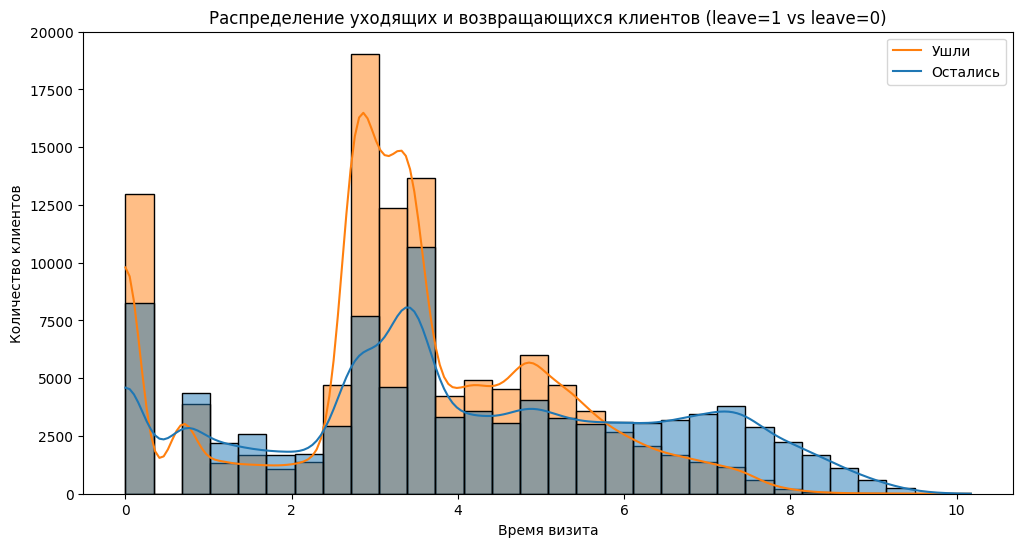

Среднее время визита:
leave
0    4.066653
1    3.296347
Name: log_visitDuration, dtype: float64


In [58]:
# Строим графики распределения 
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='log_visitDuration', hue='leave', bins=30, kde=True, palette=['#1f77b4', '#ff7f0e'])
plt.title('Распределение уходящих и возвращающихся клиентов (leave=1 vs leave=0)')
plt.xlabel('Время визита')
plt.ylabel('Количество клиентов')
plt.legend(['Ушли','Остались'])
plt.show()
#Посчитаем среднее время визита
print("Среднее время визита:")
print(data.groupby('leave')['log_visitDuration'].mean())

Видим, что и по распределению и по среднему значению те, кто меньше изучает сайт, те с большей вероятностью больше на него не вернутся

**Гипотеза 2 - Новые клиенты чаще оставляют контакты, чем те, кто посещает сайт повторно раз.**
**Что смотрим:**  
- Если медиана (`isNewUser`) с количеством посещений для `registration_left=0` ниже, чем для `registration_left=1` — гипотеза подтверждается.    

C:\Users\likha\AppData\Local\Temp\ipykernel_20860\363366197.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='registration_left', y='isNewUser', data=X_train, ci=None)


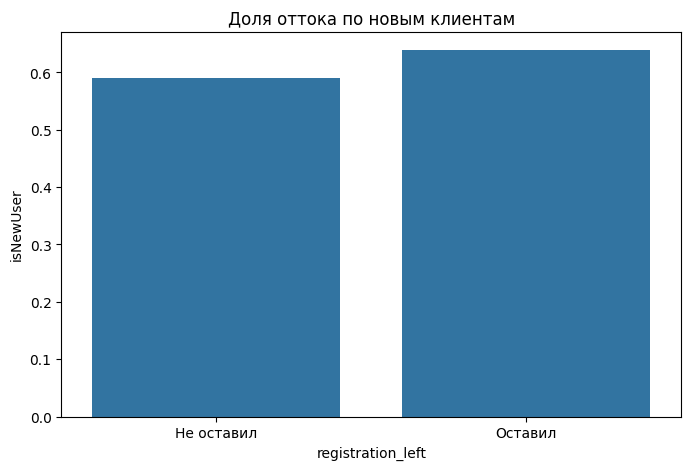

Среднее количество регистраций на визит нового клиента:
registration_left
0    0.589735
1    0.639159
Name: isNewUser, dtype: float64


In [59]:
# Переведем столбец 'registration_left' из bool в бинарный целочисленный тип данных
X_train['registration_left'] = X_train['registration_left'].astype(int)
# Строим распределения количества оставленных регистраций новыми клиентами
plt.figure(figsize=(8, 5))
sns.barplot(x='registration_left', y='isNewUser', data=X_train, ci=None)
plt.xticks([0, 1], ['Не оставил', 'Оставил'])
plt.title("Доля оттока по новым клиентам")
plt.show()

print("Среднее количество регистраций на визит нового клиента:")
print(X_train.groupby('registration_left')['isNewUser'].mean())

Гипотеза 2 подтверждена, действительно новые клиенты чаще оставляют с первого раза свои контакты, возможно это связано с тем, что ученики заходят на главную страницу сайта, чтобы перейти на обучаюший курс в личный кабинет.

**Гипотеза 3 - Больше всего клиентов компания имеет в центральной России - Москве и Санкт-Петербурге, и они чаще возвращаются на сайт.**
**Что смотрим:**  
- Если клиентов из Москвы и Санкт-Петербург будет больше остальных городов и их возвращение на сайт будет больше, значит гипотеза верна.    

Т.к. уникальных значений городов очень много, оставим только топ 10, и по ним построим график зависимости от уходов клиентов

In [60]:
category_counts = data['regionCity'].value_counts()
# Выбираем топ-N категорий
top_categories = category_counts.nlargest(10).index

# Фильтруем DataFrame, оставляя только топ-N категории
X_train_top10_city = data[data['regionCity'].isin(top_categories)]

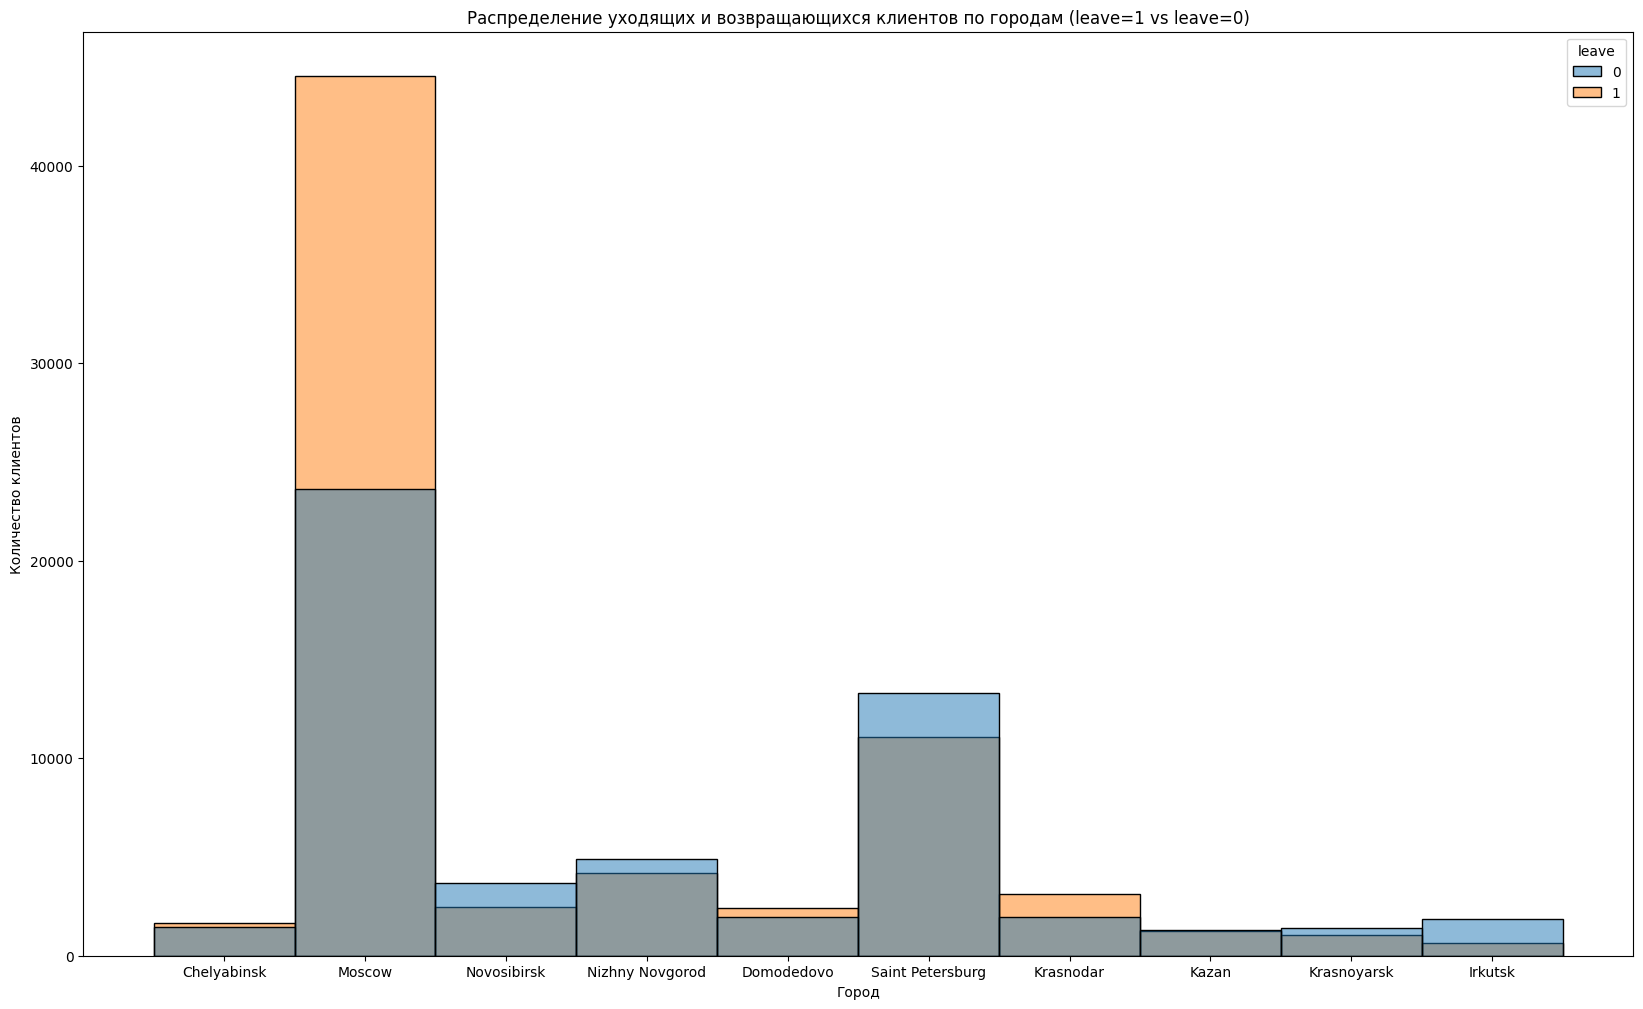

In [61]:
# Построим распределения, связывающее не возвращение на сайт и город
# Само распределение 
plt.figure(figsize=(20, 12))
sns.histplot(data=X_train_top10_city, x='regionCity', hue='leave', bins=30,)
plt.title('Распределение уходящих и возвращающихся клиентов по городам (leave=1 vs leave=0)')
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.show()

Видно, что клиенты из Москвы почти в два раза чаще не возвращаются на сайт, чем все остальные города. В Санкт-Петербурге наоборот, больше людей возвращается. Также интересные моменты, что ещё больше людей возвращаются на сайт из Нижнего-Новгорода, Иркутска и Новосибирска. Возможно там более успешные рекламные кампании проходят.

Удаляем столбец regionCity за неадобностью, т.к. есть Долгота и Широта

In [62]:
X_train=X_train.drop('regionCity', axis=1)
X_test=X_test.drop('regionCity', axis=1)

In [63]:
X_train.head()

,isNewUser,pageViews,bounce,registration_left,total_regs,Широта,Долгота,is_weekend,time_one_page,log_time_one_page,...,browser_edge,browser_googlesearch,browser_opera,browser_other,browser_safari,browser_safari_mobile,browser_samsung_internet,browser_yandex_browser,browser_yandexsearch,browser_yasearchapp
275137,0,1,1,0,0,56.324209,44.005395,0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
290764,0,5,0,0,0,55.160366,61.400786,1,277.2,5.628340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142739,1,1,0,0,0,55.753879,37.620373,0,16.0,2.833213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270562,1,1,0,0,0,55.753879,37.620373,0,18.0,2.944439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205962,1,1,0,0,0,54.984814,73.367464,0,123.0,4.820282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Применим кластеризацию, посмотрим, возможно есть какие-то группы, которые могут в последствии добавить хороший признак

С помощью метода локтя находим оптимальное количество кластеров для алгоритма KMeans, перебирая числа от 1 до 29 и вычисляя инерцию (сумму квадратов расстояний до центроидов) для каждого значения. Результат отображаем на графике, где можно увидеть "локоть" — точку, после которой улучшение инерции замедляется, и выбирается оптимальное количество кластеров.

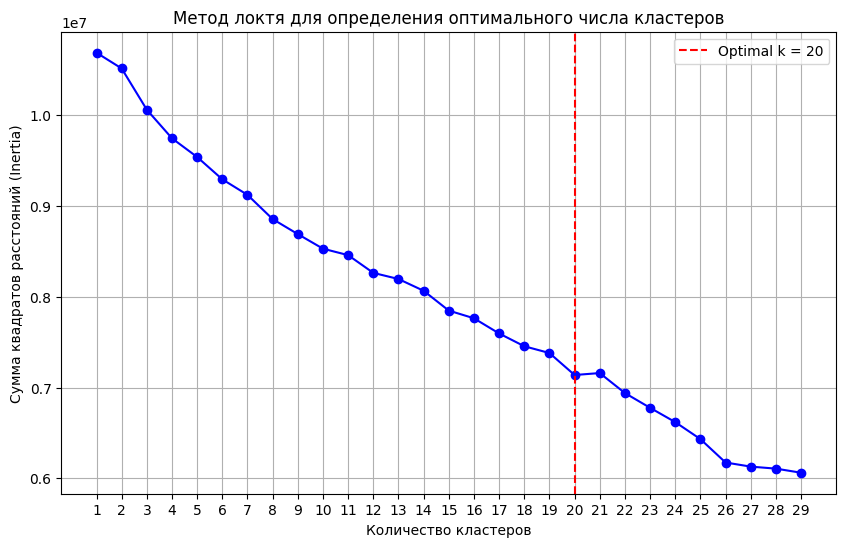

In [65]:
inertia = []
k_range = range(1, 30)  # Проверяем от 1 до 30 кластеров

for k in k_range:
    kmeans = KMeans(n_clusters=k,  n_init='auto', random_state=42)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)  # Сумма квадратов расстояний до центроидов
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний (Inertia)')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.xticks(k_range)
# поиск "локтя" (оптимального k)
# для этого найдем точку, где уменьшение inertia начинает замедляться
# используем вторую производную для нахождения точки перегиба
diff = np.diff(inertia)  # первая производная
diff2 = np.diff(diff)    # вторая производная
optimal_k = np.argmax(diff2) + 2  # +2, так как diff2 имеет длину на 2 меньше

# добавляем вертикальную линию для оптимального k
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.grid()
plt.show()

Видим, что количество кластеров получается очень большое и при этом разницы между кластерами почти нет, об этом говорят значения вертикальной оси в 10^(-7) степени, поэтому в данном случае метод кластеризации нам не нужен.

Проверим, что число признаков в тренировочных данных и тестовых совпадает.


In [66]:
# выведем размеры частей
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled:",  X_test_scaled.shape) 

X_train_scaled: (161948, 66)
X_test_scaled: (40488, 66)


Мы убедились, что как обучающая, так и тестовая выборки имеют одинаковое число итоговых признаков

Отбор признаков и построение корреляционной матрицы

['isNewUser', 'pageViews', 'bounce', 'registration_left', 'total_regs', 'Широта', 'Долгота', 'is_weekend', 'time_one_page', 'log_time_one_page', 'log_visitDuration', 'start_url_domain_encoded', 'end_url_domain_encoded', 'lastTrafficSource_direct', 'lastTrafficSource_email', 'lastTrafficSource_internal', 'lastTrafficSource_organic', 'lastTrafficSource_other', 'lastTrafficSource_referral', 'lastTrafficSource_social', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'referer_domain_education.maximumtest.ru', 'referer_domain_google.com', 'referer_domain_google.ru', 'referer_domain_login.maximumtest.ru', 'referer_domain_maximumtest-ru.turbopages.org', 'referer_domain_maximumtest.ru', 'referer_domain_other', 'referer_domain_propostuplenie-ru.turbopages.org', 'referer_domain_propostuplenie.ru', 'referer_domain_pruffme.com', 'referer_domain_ya

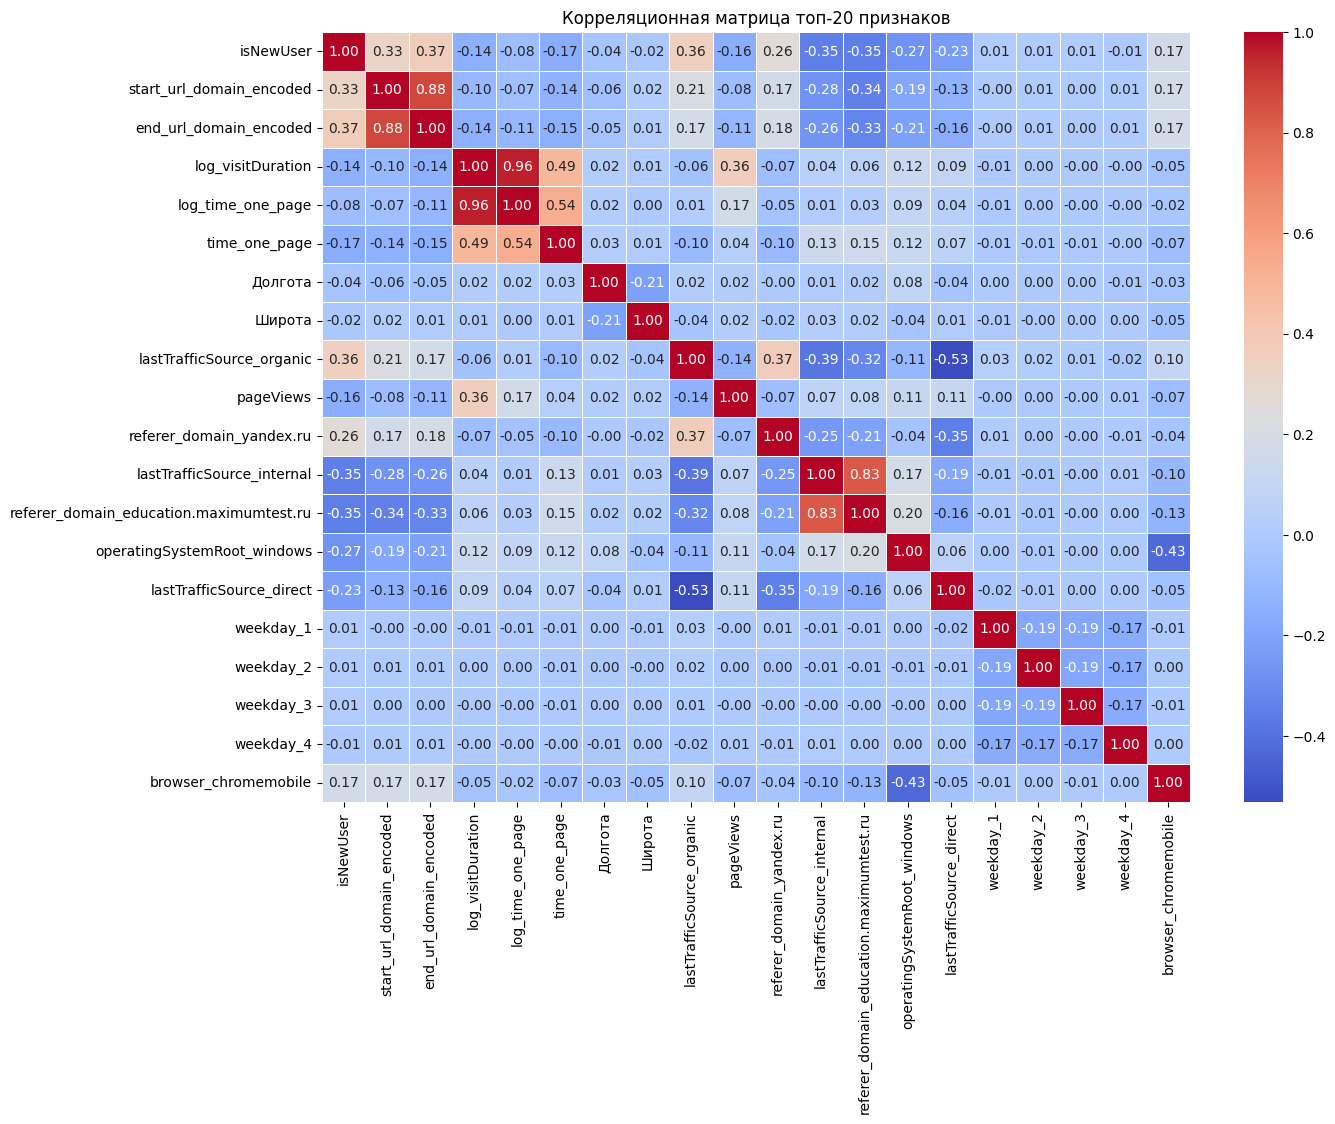

In [67]:
# 1. Составим список названий признаков
X_train_final = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)  # стандартизированные признаки
X_test_final = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

original_feature_names = [col for col in X_train.columns]
print(original_feature_names)

# 2. Обучим модель
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, y_train)

# 3. Получим важности
feature_importances = model.feature_importances_

# 4. DataFrame с признаками и важностями
feature_df = pd.DataFrame({
    'Feature': original_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 5. Возьмем топ-20 признаков
top_features = feature_df.head(20)
print(top_features)

# 6. Создаем DataFrame с этими признаками из X_train_final
top_feature_names = top_features['Feature'].tolist()
top_feature_indexes = [original_feature_names.index(name) for name in top_feature_names]

X_top_df = X_train_final.iloc[:, top_feature_indexes]
X_top_df.columns = top_feature_names

# 7. Построим корреляционную матрицу
correlation_matrix = X_top_df.corr()

# 8. Визуализируем
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица топ-20 признаков")
plt.show()

Выше мы построили корреляционную матрицу, которая помогает выявить взаимосвязи между признаками, показывая, насколько сильно они влияют друг на друга.  
Визуализация корреляции помогает легче интерпретировать эти зависимости.

### **4. Выбор и построение модели машинного обучения**

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score, learning_curve
from xgboost import XGBClassifier

Для применения алгоритма Логистическая регрессия требуется нормализация данных. Для методов случайный лес и градиентный бустинга она не обязательна, т.к. они не чувствительны к масштабу признаков, поскольку рассматривают признаки независимо друг от друга при выборе наилучшего разделения.

Разделение на обучение и валидацию, чтобы выбрать модель на основании метрик

In [69]:
X_train_val_df=pd.DataFrame(X_train_final)
X_train_val_df.isnull().sum()

isNewUser                   0
pageViews                   0
bounce                      0
registration_left           0
total_regs                  0
                           ..
browser_safari_mobile       0
browser_samsung_internet    0
browser_yandex_browser      0
browser_yandexsearch        0
browser_yasearchapp         0
Length: 66, dtype: int64

Приступаем к проектированию моделей
#### Модель 1 - Логистическая регрессия с учетом дисбаланса

In [70]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train_final, y_train)

print(classification_report(y_test, lr.predict(X_test_final)))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86     18494
           1       0.86      0.92      0.89     21994

    accuracy                           0.88     40488
   macro avg       0.88      0.87      0.88     40488
weighted avg       0.88      0.88      0.88     40488



Рассмотрим метрики, которые у нас получились:
1. precision (Точность): эта метрика показывает, какой процент предсказанных положительных значений (класс 1) оказался правильным. Для класса 1 точность равна 0.86, что означает, что из всех предсказанных положительных случаев 86% действительно были положительными. Для класса 0 точность равна 0.90, то есть 90% из предсказанных отрицательных случаев были действительно отрицательными.
2. recall (Полнота): показывает, какой процент фактических положительных значений (класс 1) был правильно предсказан. Для класса 1 полнота равна 0.92, что означает, что модель правильно идентифицировала 92% всех реальных положительных случаев. Для класса 0 полнота равна 0.83, что означает, что модель правильно определила 83% всех реальных отрицательных случаев.
3. f1-score (F1-оценка): это среднее гармоническое от точности и полноты. Она учитывает как ложноположительные, так и ложноотрицательные ошибки. F1-оценка для класса 1 равна 0.89, а для класса 0 — 0.86. Это говорит о хорошем балансе между точностью и полнотой для обоих классов.
4. support (Поддержка): это количество примеров в каждом классе в тестовом наборе. В нашем случае для класса 0 — 18,494 примера, для класса 1 — 21,994 примера.
5. accuracy (Точность): это общая доля правильных предсказаний по всем классам. В данном случае точность модели составляет 88%, что означает, что 88% всех предсказаний модели были правильными.
6. macro avg (Среднее по классам): это среднее значение по меткам классов для точности, полноты и F1-оценки. Он показывает средний результат, не принимая во внимание размер классов.
7. weighted avg (Взвешенное среднее): это среднее значение по меткам классов с учетом их поддержки (количества примеров в классе). Это позволяет учитывать дисбаланс классов.


Сравненим метрики на обучающей и тестовой выборках

In [71]:
# Предсказания на обучающей выборке
train_preds = lr.predict(X_train_final)
print("Отчет по обучающей выборке:")
print(classification_report(y_train, train_preds))

# Предсказания на тестовой выборке
test_preds = lr.predict(X_test_final)
print("Отчет по тестовой выборке:")
print(classification_report(y_test, test_preds))


Отчет по обучающей выборке:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     73974
           1       0.86      0.92      0.89     87974

    accuracy                           0.88    161948
   macro avg       0.88      0.88      0.88    161948
weighted avg       0.88      0.88      0.88    161948

Отчет по тестовой выборке:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     18494
           1       0.86      0.92      0.89     21994

    accuracy                           0.88     40488
   macro avg       0.88      0.87      0.88     40488
weighted avg       0.88      0.88      0.88     40488



Отчеты по обучающей и тестовой выборкам показывают, что модель логистической регрессии с учетом дисбаланса работает как на обучающих, так и на тестовых данных.

Посмотрим как модель работает на разных частях данных с помощью кросс-валидации.

In [72]:
# F1 по классу 1
f1_scorer = make_scorer(f1_score, pos_label=1)

# 5-кратная кросс-валидация
scores = cross_val_score(lr, X_train_final, y_train, cv=5, scoring=f1_scorer)

print("F1-оценки по фолдам:", scores)
print("Среднее значение F1:", scores.mean())
print("Стандартное отклонение:", scores.std())


F1-оценки по фолдам: [0.89405756 0.89284339 0.89176374 0.89296284 0.8940401 ]
Среднее значение F1: 0.8931335252821194
Стандартное отклонение: 0.0008561936000441877


Результаты 5-кратной кросс-валидации для F1-оценки по классу 1 с моделью логистической регрессии показывают следующие ключевые моменты:

F1-оценки по фолдам:
[0.89405756, 0.89284339, 0.89176374, 0.89296284, 0.8940401] — Эти значения показывают, как F1-оценка модели варьируется по 5 фолдам (разделам данных).

Все оценки F1 находятся в пределах 0.89, что указывает на стабильность модели и хорошее качество предсказаний для класса 1 в разных частях данных.

Среднее значение F1:
0.8931335252821194 — Средняя F1-оценка по всем фолдам. Это значение отражает общий баланс между точностью и полнотой модели по классу 1, что является хорошим показателем качества классификации.

Стандартное отклонение:
0.0008561936000441877 — Стандартное отклонение F1-оценки по фолдам. Это очень низкое значение, что указывает на то, что модель стабильно работает на всех фолдах и не имеет значительных колебаний в качестве предсказаний.

**Обобщающий анализ метрик логистической регрессии:**

**По классу 0 (клиенты остаются):**  
Precision = 0.90 — Из всех предсказанных "остающихся" 90% действительно остаются.  
Recall = 0.83 — Модель выявляет 83% реально остающихся клиентов.

**По классу 1 (клиенты уходят):**  
Precision = 0.86 — 86% предсказанных уходов действительно уходят.  
Recall = 0.92 — Модель выявляет 92% реальных уходящих клиентов.

**Общие метрики:**  
Accuracy = 0.88 — Общая точность модели составляет 88%, что указывает на хорошую производительность.  
F1-score для класса 1 = 0.89 — Отличный баланс между точностью и полнотой для уходящих клиентов (класс 1).

Вывод: Модель имеет высокие значения recall для обоих классов (особенно для класса 1), что означает, что она успешно выявляет как остающихся, так и уходящих клиентов. При этом точность для класса 1 выше, чем для класса 0, что свидетельствует о хорошей способности модели правильно классифицировать уходящих клиентов.

#### Модель 2 - Random Forest

In [73]:
# настройка стратегии валидации (сохраняем дисбаланс)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# создаем кастомную метрику (F1 для класса 1 - "уход")
scorer = make_scorer(f1_score, pos_label=1)

# расширенная сетка параметров
param_dist = {
    'n_estimators': [200, 300],     # число деревьев
    'max_depth': [4, 5, 7],         # глубина
    'min_samples_leaf': [1, 3, 5],       # мин. листьев
    'max_features': ['sqrt', 0.8]        # как выбирать фичи
}

rf = RandomForestClassifier(
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

# инициализация модели
model = RandomForestClassifier(random_state=42)

rnd_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,             # всего 10 случайных сочетаний
    cv=cv,
    scoring=scorer,
    random_state=42,
    verbose=2
)

rnd_search.fit(X_train_final, y_train)

print("Лучшие параметры:", rnd_search.best_params_)
print("Лучший F1-score (CV):", rnd_search.best_score_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=7, max_features=0.8, min_samples_leaf=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=7, max_features=0.8, min_samples_leaf=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=7, max_features=0.8, min_samples_leaf=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=7, max_features=0.8, min_samples_leaf=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=7, max_features=0.8, min_samples_leaf=5, n_estimators=300; total time= 1.1min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=  10.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=  10.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=   9.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=300; total time=  11.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n

Лучшие параметры модели RandomForestClassifier включают 300 деревьев, максимальную глубину 7 и использование 80% признаков для каждого дерева, что позволяет достичь F1-score 0.895. Это указывает на высокую эффективность модели в задаче прогнозирования ухода клиентов, обеспечивая хороший баланс между точностью и полнотой.

Проверим модель на тестовых данных

In [74]:
best_model = rnd_search.best_estimator_
y_pred = best_model.predict(X_test_final)
print("\nОтчет на тестовых данных:")
print(classification_report(y_test, y_pred))


Отчет на тестовых данных:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     18494
           1       0.86      0.93      0.89     21994

    accuracy                           0.88     40488
   macro avg       0.88      0.87      0.88     40488
weighted avg       0.88      0.88      0.88     40488



На тестовых данных модель также показывает хорошие результаты:

Для класса 0 (клиенты остаются):  
Precision = 0.91, Recall = 0.82, F1-score = 0.86  
Это означает, что из всех предсказанных оставшихся клиентов 91% действительно остаются, но модель не выявляет всех реально оставшихся (только 82%).

Для класса 1 (клиенты уходят):  
Precision = 0.86, Recall = 0.93, F1-score = 0.89  
Это означает, что модель точно предсказывает 86% уходящих клиентов и хорошо находит 93% всех уходящих.

Общая accuracy = 0.88, что подтверждает стабильную работу модели на всех данных.

Модель отлично справляется с прогнозированием ухода клиентов, с хорошим балансом между точностью и полнотой, особенно для класса 1.

Проверим на переобучение

In [75]:
# Метрики на обучающих данных
y_train_pred = best_model.predict(X_train_final)
print("Отчет на обучающих данных:")
print(classification_report(y_train, y_train_pred))

# Метрики на тестовых данных
y_test_pred = best_model.predict(X_test_final)
print("Отчет на тестовых данных:")
print(classification_report(y_test, y_test_pred))


Отчет на обучающих данных:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     73974
           1       0.86      0.93      0.90     87974

    accuracy                           0.88    161948
   macro avg       0.89      0.88      0.88    161948
weighted avg       0.88      0.88      0.88    161948

Отчет на тестовых данных:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     18494
           1       0.86      0.93      0.89     21994

    accuracy                           0.88     40488
   macro avg       0.88      0.87      0.88     40488
weighted avg       0.88      0.88      0.88     40488



Видим, что модель не переобучена, так как нет значительных различий между показателями на обучающих и тестовых данных, и она стабильно показывает высокие результаты на обоих наборах данных.

Проведем также кросс-валидацию, чтобы понять, работает ли модель на всех данных одинаково хорошо

In [76]:
# Кросс-валидация на обучающей выборке
cv_scores = cross_val_score(best_model, X_train_final, y_train, cv=5, scoring='f1')
print(f"Кросс-валидация F1-оценки: {cv_scores}")
print(f"Среднее значение F1: {cv_scores.mean()}")
print("Стандартное отклонение:", cv_scores.std())


Кросс-валидация F1-оценки: [0.89521933 0.89385597 0.89295652 0.89379446 0.89633846]
Среднее значение F1: 0.894432947407279
Стандартное отклонение: 0.0011974801120966812


Результаты кросс-валидации подтверждают, что модель имеет хорошую производительность и стабильность.

Ниже рассмотрим график кривой обучения, который показывает, как меняется F1-оценка модели в зависимости от размера обучающей выборки.  
На графике будут две линии: одна для тренировочных данных и другая для тестовых.  
Ось X — это размер обучающей выборки. Как правило, начинаем с малых объемов данных и постепенно увеличиваем их.  
Ось Y — это F1-оценка, которая показывает, насколько хорошо модель находит баланс между точностью и полнотой.

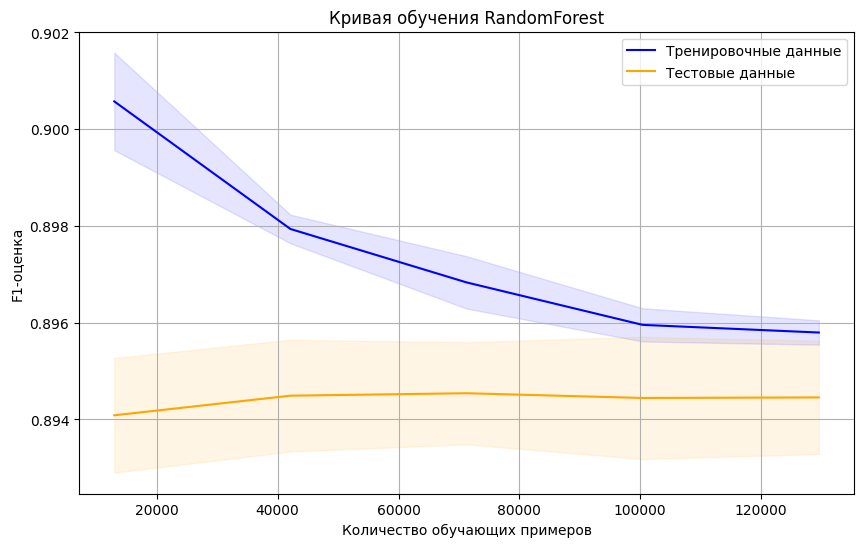

In [77]:
# Построение кривой обучения
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_final, y_train, cv=5, scoring='f1', n_jobs=-1
)

# Средние значения и стандартное отклонение
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Стандартные отклонения
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Тренировочные данные', color='blue')
plt.plot(train_sizes, test_mean, label='Тестовые данные', color='orange')

# Оттенки доверительного интервала
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.title('Кривая обучения RandomForest')
plt.xlabel('Количество обучающих примеров')
plt.ylabel('F1-оценка')
plt.legend()
plt.grid(True)
plt.show()


На графике мы видим, что тренировочная линия упала с 0.901 до 0.896, а тестовая линия выросла с 0.8940 до 0.8945. Это не значительные изменения параметра в обоих случаях, поэтому можно говорить о том, что с увеличением объема данных качество работы модели не изменяется критично.

По показателям выше, можем сделать вывод, что модель не переобучена.  
* Метрики на обучающей и тестовой выборках совпадают (F1 ≈ 0.90)  
* Кросс‑валидация показывает очень стабильные результаты (mean F1 ≈ 0.894, σ ≈ 0.001)  

Всё это говорит о том, что модель хорошо обобщает и не «запомнила» только тренировочные данные.

**Обобщающий анализ метрик Random Forest:**

1. **По классу 0 (клиенты остаются)**:
   - Precision = 0.91 — из предсказанных «остающихся» 91% действительно остались
   - Recall = 0.82 — модель выявляет 82% всех реально остающихся клиентов
   - F1 = 0.86 — хороший баланс между точностью и полнотой для остающихся клиентов.

2. **По классу 1 (клиенты уходят)**:
   - Precision = 0.86 — из предсказанных «уходящих» 86% действительно уходят.
   - Recall = 0.93 — модель находит 93% всех реальных уходов.
   - F1 = 0.90 — модель очень точно и полно обнаруживает уходящих клиентов.

3. **Общие показатели**:
   - Accuracy = 0.88 — 88% всех предсказаний (и остающиеся, и уходящие) оказались правильными.
   - Macro avg F1 = 0.88 — среднее F1‑значение по классам.
   - Weighted avg F1 = 0.88 — взвешенное по количеству примеров среднее F1.

#### Модель 3 - Градиентный спуск с подбором гиперпараметров 

In [78]:
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# подбор параметров
params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'scale_pos_weight': [1, 3, 5, 10]
}

grid = GridSearchCV(xgb, params, cv=5, scoring='f1')
grid.fit(X_train_final, y_train)

best_xgb = grid.best_estimator_
print(f"Лучшие параметры: {grid.best_params_}")
print(classification_report(y_test, best_xgb.predict(X_test_final)))


Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 1}
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     18494
           1       0.86      0.93      0.89     21994

    accuracy                           0.88     40488
   macro avg       0.89      0.88      0.88     40488
weighted avg       0.88      0.88      0.88     40488



Лучшие параметры градиентного бустинга XGBClassifier были найдены как:  
learning_rate = 0.1, max_depth = 5, scale_pos_weight = 1  
При этом модель показывает precision/recall/F1 для класса “остаются” 0.91/0.82/0.86 и для класса “уходят” 0.86/0.93/0.89, с общей accuracy = 0.88 и macro‑avg F1 = 0.88.  
Это означает, что XGBoost с выбранными гиперпараметрами обеспечивает такой же высокий баланс между точностью и полнотой, как и Random Forest.

Проверим на переобучение

In [79]:
# Метрики на обучающих данных
print("Отчет на обучающих данных:")
print(classification_report(y_train, best_xgb.predict(X_train_final)))

# Метрики на тестовых данных
print("Отчет на тестовых данных:")
print(classification_report(y_test, best_xgb.predict(X_test_final)))


Отчет на обучающих данных:
              precision    recall  f1-score   support

           0       0.91      0.82      0.87     73974
           1       0.86      0.93      0.90     87974

    accuracy                           0.88    161948
   macro avg       0.89      0.88      0.88    161948
weighted avg       0.89      0.88      0.88    161948

Отчет на тестовых данных:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     18494
           1       0.86      0.93      0.89     21994

    accuracy                           0.88     40488
   macro avg       0.89      0.88      0.88     40488
weighted avg       0.88      0.88      0.88     40488



Модель не переобучена: метрики на обучающих и тестовых данных практически совпадают.

In [80]:
cv_scores = cross_val_score(best_xgb, X_train_final, y_train, cv=5, scoring='f1')
print("F1 по кросс-валидации:", cv_scores)
print("Среднее:", cv_scores.mean())
print("Стандартное отклонение:", cv_scores.std())


F1 по кросс-валидации: [0.89617636 0.89617456 0.89417224 0.89498488 0.8978196 ]
Среднее: 0.8958655295352717
Стандартное отклонение: 0.0012371982739604063


F1‑оценки по 5‑фолдовой кросс‑валидации лежат практически не отличаются со средним 0.8959 и низким стандартным отклонением 0.001, что говорит о высокой и стабильной производительности модели.

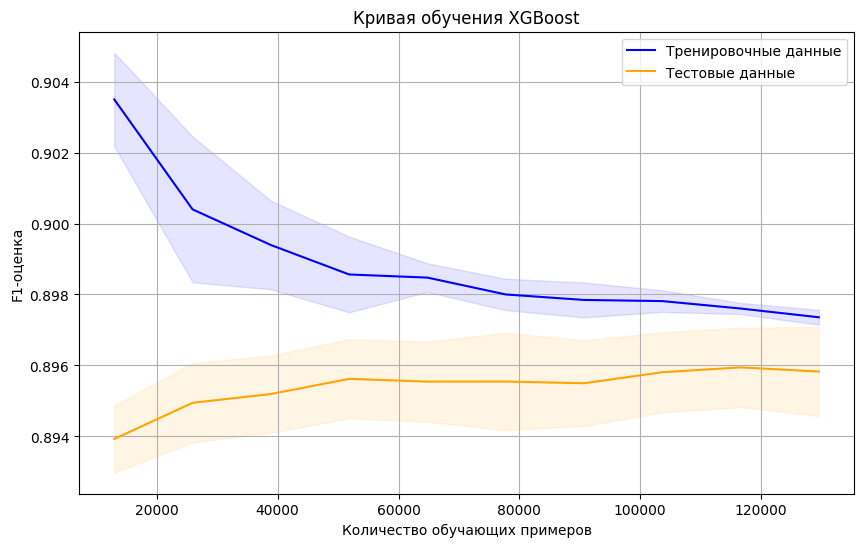

In [81]:
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb,                   # модель
    X_train_final,               # признаки
    y_train,               # целевая переменная
    cv=5,                      # кросс-валидация
    scoring='f1',              # используем F1-оценку
    n_jobs=-1,                 # все доступные ядра
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 точек от 10% до 100%
    shuffle=True,
    random_state=42
)

# Средние значения
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Стандартные отклонения
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Тренировочные данные', color='blue')
plt.plot(train_sizes, test_mean, label='Тестовые данные', color='orange')

# Оттенки доверительного интервала
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.title('Кривая обучения XGBoost')
plt.xlabel('Количество обучающих примеров')
plt.ylabel('F1-оценка')
plt.legend()
plt.grid(True)
plt.show()


На этом графике показано, как качество модели (F1‑оценка) меняется с ростом объёма обучающих данных:

Синяя линия — F1 на самой обучающей выборке: при малом количестве данных она близка к 1 (модель «запоминает» их), но по мере добавления примеров постепенно снижается и выходит на стабильный уровень.

Оранжевая линия — F1 по тестовым данным: при небольших объёмах заметно ниже, но по мере роста выборки растёт и стремится к уровню обучающей кривой.

Заливки вокруг линий показывают разброс оценок по фолдам: узкий интервал говорит о стабильности результатов.

Обе кривые сходятся и больше не растут при увеличении данных, значит модель достигла своей ёмкости и добавление новых примеров вряд ли улучшит качество.

**Обобщающий анализ метрик Градиентного спуска**


**1. По классу 1 (уходящие клиенты) – ключевая задача**  
- **Recall = 0.93** → **93% уходящих клиентов правильно предсказано** 
- **Precision = 0.86** → **86% предсказанных уходящих клиентов верны**
- **F1 = 0.90** → **Сбалансированное сочетание Precision и Recall**

**Вывод:**  
- **Модель хорошо справляется с предсказанием ухода клиентов как на обучающих, так и на тестовых данных, с очень высокой чувствительностью (Recall) и хорошей точностью (Precision). Производительность модели на обучающих и тестовых данных почти одинаковая, что свидетельствует о хорошем обобщении.**  

**2. По классу 0 (не уходят) – второстепенная задача**  
- **Precision = 0.91** → **91% предсказанных "не уходящих клиентов" верны** 
- **Recall = 0.82** → **82% "не уходящих клиентов" правильно предсказано**
- **F1 = 0.87** → **Понижение F1 на тестовых данных по сравнению с обучающими, но в целом результат остаётся высоким**

**Вывод:**  
- **Модель неплохо предсказывает "не уходящих клиентов", несмотря на то, что задача второстепенная. Однако на тестовых данных есть небольшое снижение точности и полноты, что может быть связано с небольшим дисбалансом данных.**

**Общие метрики**  
- **Accuracy = 0.88** → **88% всех предсказаний верны**
- **Weighted F1 = 0.88** → **Хорошо сбалансированное качество предсказаний для обоих классов**
 **Вывод:**  
- **Общая производительность на уровне Random Forest**  

**Вывод:**  
- **Модель демонстрирует хорошую точность и сбалансированную производительность на обоих наборах данных, с тем же значением Accuracy и Weighted F1 на обучающих и тестовых данных. Это подтверждает, что модель не переобучилась и стабильно работает на новых данных.**

Сделаем общую таблицу, чтобы было легче сравнивать

In [82]:
from sklearn.metrics import f1_score, recall_score, precision_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    'Logistic Regression': lr,
    'Random Forest': best_model,
    'XGBoost': best_xgb
}

results = []
for name, model in models.items():
    pred = model.predict(X_test_final)
    results.append({
        'Model': name,
        'Recall': recall_score(y_test, pred, pos_label=1),
        'Recall_weighted': recall_score(y_test, pred, average='weighted'),
        'F1-Score': f1_score(y_test, pred, pos_label=1),
        'F1_weighted': f1_score(y_test, pred, average='weighted'),
        'Precision': precision_score(y_test, pred, pos_label=1)
    })

result_df = pd.DataFrame(results).sort_values('Recall', ascending=False)
display(result_df)


,Model,Recall,Recall_weighted,F1-Score,F1_weighted,Precision
2,XGBoost,0.930845,0.880878,0.894623,0.880183,0.861115
1,Random Forest,0.928208,0.879223,0.893045,0.878544,0.860448
0,Logistic Regression,0.922433,0.877840,0.891349,0.877256,0.862292


**Сравнение моделей:**  
XGBoost показывает наилучшие результаты по метрикам Recall, F1 и почти совпадает по Precision с Logistic Regression что делает её наиболее эффективной моделью для задачи прогнозирования ухода клиентов.

Random Forest очень близка к XGBoost по результатам, с небольшим отставанием по Recall и F1.

Logistic Regression показывает немного более низкие результаты, но по-прежнему остаётся достаточно конкурентоспособной, особенно в плане Precision.

**Итог:** для наилучших результатов в предсказаниях ухода клиентов лучше выбрать XGBoost, а для простоты и скорости можно использовать Logistic Regression.

Составим графики важности признаков, чтобы посмотреть, какие признаки оказывают наибольшее влияние на предсказания модели. Визуализация позволяет легко сравнить важность различных признаков для каждой модели.

Логистическая регрессия


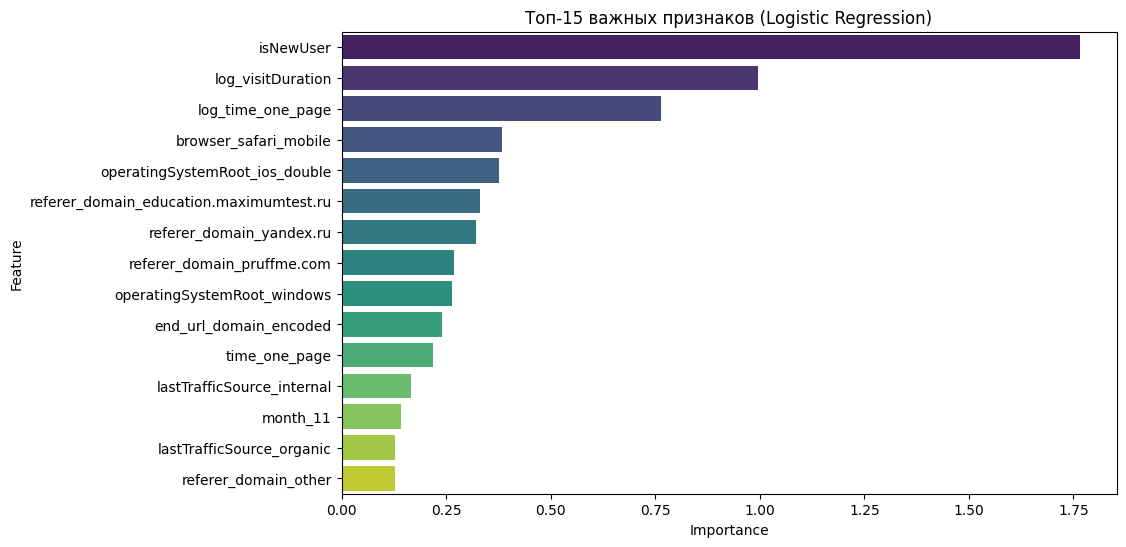

Random Forest


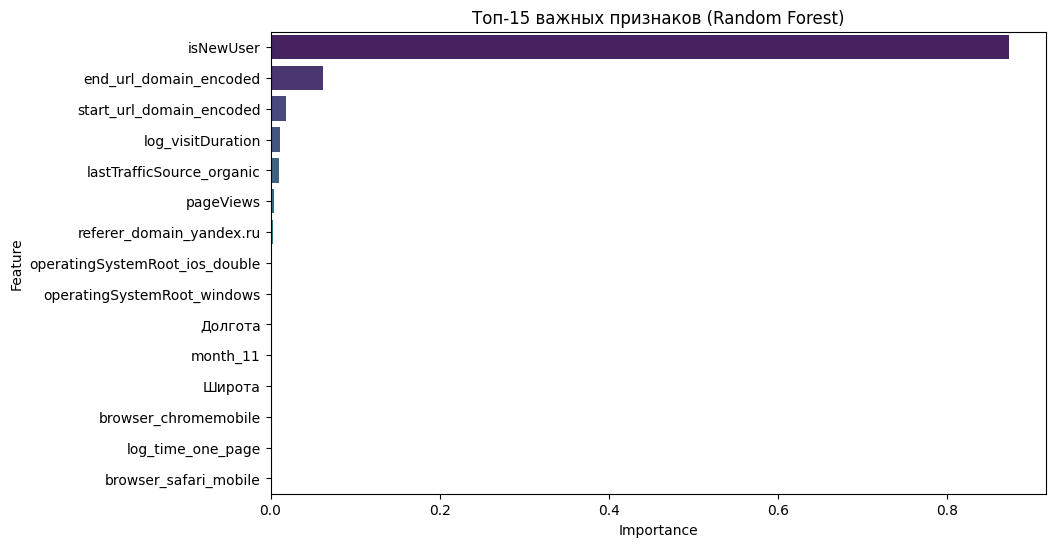

XGBoost


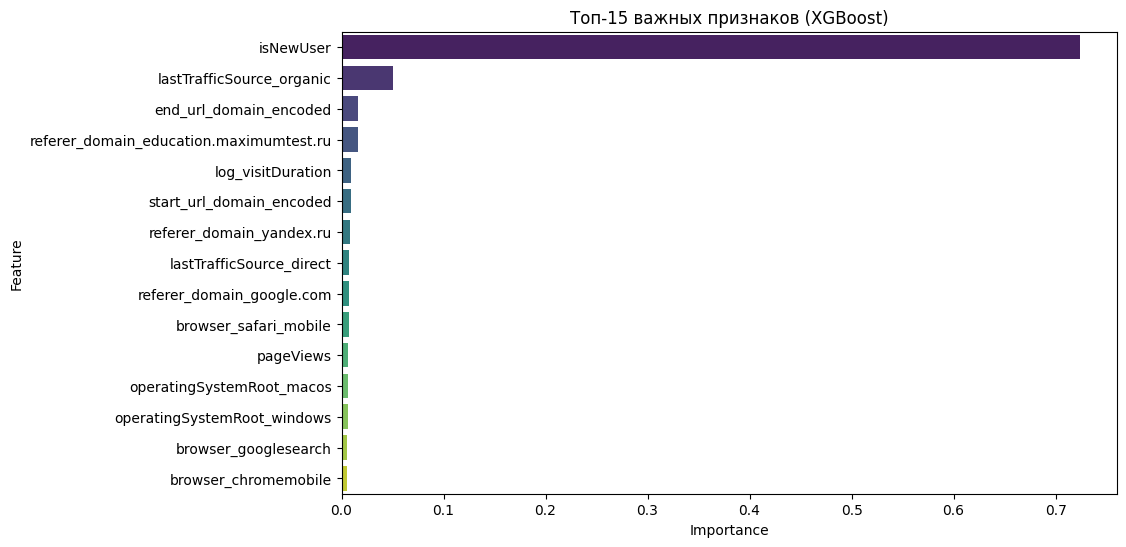

In [83]:
# Функция для получения важности признаков
def get_feature_importance(model, feature_names):
    """Возвращает важность признаков в виде DataFrame"""
    if hasattr(model, 'coef_'):
        # Для логистической регрессии
        return pd.DataFrame({
            'Feature': feature_names[:len(model.coef_[0])],  # Защита от несоответствия размеров
            'Importance': abs(model.coef_[0])
        }).sort_values('Importance', ascending=False)
    elif hasattr(model, 'feature_importances_'):
        # Для RandomForest и XGBoost
        return pd.DataFrame({
            'Feature': feature_names[:len(model.feature_importances_)],
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
    else:
        raise ValueError("Модель не имеет атрибутов для извлечения важности признаков.")

# Функция для визуализации важности признаков
def plot_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_features, hue='Feature', palette='viridis', legend=False)
    plt.title(f'Топ-15 важных признаков ({title})')
    plt.show()

# Пример использования для 3 моделей
# Получаем список признаков
feature_names = X_train_final.columns if isinstance(X_train_final, pd.DataFrame) else ['feature_{}'.format(i) for i in range(X_train_final.shape[1])]

# 1. Получаем важность признаков для всех моделей
importance_lr = get_feature_importance(lr, feature_names)
importance_rf = get_feature_importance(best_model, feature_names)
importance_xgb = get_feature_importance(best_xgb, feature_names)

# 2. Визуализация для каждой модели
print("="*50 + "\nЛогистическая регрессия\n" + "="*50)
plot_importance(importance_lr, "Logistic Regression")

print("="*50 + "\nRandom Forest\n" + "="*50)
plot_importance(importance_rf, "Random Forest")

print("="*50 + "\nXGBoost\n" + "="*50)
plot_importance(importance_xgb, "XGBoost")


Из представленной таблицы видно, как различные признаки влияют на три модели: логистическую регрессию (LR), случайный лес (RF) и XGBoost (XGB). Рассмотрим несколько выводов:  

**Значимость признаков в моделях:**


Однозначным лидером по важности во всех моделях стал признак: isNewUser.
Также высокозначимым в моделях была длительность посещения сайта, в логистической регрессии она заняла второе место.
Интересно отметить, что месяц захода на сайт почти не влияет на результаты, кроме ноября, видимо на этот месяц приходится один из пиков ажиотажа, хотя градиентный бустинг не счел и его важным.
Ещё одними лидерами моделей стали признаки, означающие стартовую и конечную веб-страницы. 

# 5. Итог

Подведем итоги по созданию модели машинного обучения:

Признаки, связанные с новизной клиента, длительности посещения, а также где начал и закончил клиент, оказывают наиболее сильное влияние на то, посетит ли клиент сайт ещё раз или нет.
Полученная модель с помощью XGBoost, показала отличные результаты предсказания уходящих клиентов, более 93% предсказаний верны.

**Время выполнения кода:**

In [84]:
%time end_time = time.time()

execution_time = end_time - start_time
print(f"Общее время выполнения ноутбука: {execution_time/60} минут")

CPU times: total: 0 ns
Wall time: 21.2 μs
Общее время выполнения ноутбука: 56.18183141549428 минут
